# **<h3 align="center"> Big Data Analytics - Project </h3>**
# **<h3 align="center">Stock Sentiment</h3>**
### **<h3 align="center">Prediction market behavior from US News Notebook</h3>**

**Group _ members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>

# Table of Contents
1. Introduction  
2. Necessary Extensions and Imports
3. News Data Pipeline  
   - 3.1 Ingest and Inspect News Data  
   - 3.2 Group Articles by Day and Topic  
   - 3.3 TF-IDF Feature Extraction  
   - 3.4 Sentiment Analysis Using BERT  
4. News Data Pipeline   
5. Exploratory Data Analysis (EDA)  
6. Machine Learning  
7. Predictive Modeling  
8. Insights and Conclusions






# 1. Introduction

In this notebook, we analyze news articles from the New York Times over a 1-year period (April 2024 to April 2025). Our goal is to extract topic-specific features from headlines using TF-IDF and correlate them with market behavior (specifically, the SPY stock index). The main steps include:

- Pulling and storing NYT and SPY stock data
- Preprocessing and grouping headlines by topic and day
- Computing daily TF-IDF vectors per topic
- Generating pivot tables of article counts and TF-IDF values
- Joining with stock market data for correlation analysis


# 2. Necessary Extensions and Imports

In this section, we install any required extensions and import the necessary libraries to support the operations throughout the notebook, including data ingestion, processing, and analysis.



In [0]:
# Upgrade typing_extensions to a version MLflow expects
%pip install --upgrade typing_extensions

%pip install alpaca_trade_api

# Install (or reinstall) MLflow
%pip install --upgrade mlflow

#Since we decided to use XGBoost as an ml algorithm we need to also install
%pip install xgboost

# Restart the Python process so the new packages take effect
dbutils.library.restartPython()


import requests, json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour

from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, col, concat_ws, collect_list, count, window
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import PipelineModel

import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

import os
os.environ["PYSPARK_PIN_THREAD"] = "false"


Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa61d53b-5048-47f5-8e96-7319a9b6ec9a
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa61d53b-5048-47f5-8e96-7319a9b6ec9a
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsaf

**!Only Run when all data sets are created!**

Reestablishes Hive lookups for the Delta tables

In [0]:
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION "/mnt/nyt/archive_yearly_delta"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION "/mnt/nyt/news_tfidfs"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION "/mnt/nyt/stock_daily"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_news_merged
  USING DELTA
  LOCATION "/mnt/nyt/stock_news_merged"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS pagerank_by_day
  USING DELTA
  LOCATION "/mnt/nyt/pagerank_by_day"
""")

Out[1]: DataFrame[]

# 3. News Data Pipeline  

In the following cells, we will load and inspect the NYT headlines dataset
We start by reading the cleaned and partitioned news data from the Delta table `nyt_archive`.

It is also important to understand our use of first Delta and then Hive.
| Step                  | Component        | Purpose                                                                                                |
| --------------------- | ---------------- | ------------------------------------------------------------------------------------------------------ |
| **1. Save data**      | **Delta format** | Efficient, ACID-compliant storage of large datasets. We write the table with this format.                  |
| **2. Register table** | **Hive table**   | Adds a logical name (`nyt_archive`) to the Delta data so we can query it with SQL or `spark.table()`. |

We use Delta to store the data efficiently and Hive to make it easy to access and query. It’s the combination that gives us both performance and usability.

## 3.1. Ingest and Inspect News Data




In [0]:
# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION "/mnt/nyt/archive_yearly_delta"
""")


Out[5]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL nyt_archive;

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 5e026a8a-0609-4173-89be-d284bc817778 spark_catalog.default.nyt_archive null dbfs:/mnt/nyt/archive_yearly_delta 2025-06-02T09:23:57.471+0000 2025-06-02T14:36:52.000+0000 List(yr, mo, dy, hr) 5364 9947554 Map() 1 2 List(appendOnly, invariants) Map()

In [0]:
# Deletes everything under that path, recursively
dbutils.fs.rm("/mnt/nyt/archive_yearly_delta", recurse=True)


Out[1]: True

In [0]:
# =============================
# NYTimes Archive Ingestion
# =============================

API_KEY     = "9cLqd9jAufochxZTdf3XW0MVh4mvzGIO"
BASE_URL    = "https://api.nytimes.com/svc/archive/v1"
DELTA_PATH  = "/mnt/nyt/archive_yearly_delta"   # final Delta store

# Importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour
import requests
import json


# Let's Initialize Spark
spark = SparkSession.builder.getOrCreate()

# We define that the date range will: April 2024 → April 2025
start_year, start_month = 2025, 1
end_year,   end_month   = 2025, 4

months = []
y, m = start_year, start_month
while (y < end_year) or (y == end_year and m <= end_month):
    months.append((y, m))
    m += 1
    if m == 13:
        m = 1
        y += 1

# Loop and append each month’s headlines to Delta 
for y, m in months:
    url    = f"{BASE_URL}/{y}/{m}.json"
    params = {"api-key": API_KEY}

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    docs = resp.json().get("response", {}).get("docs", [])
    if not docs:
        continue

    # parallelize & read JSON
    rdd = spark.sparkContext.parallelize([json.dumps(d) for d in docs])
    df  = spark.read.json(rdd)

    # Select only the relevant fields for analysis:
    # - 'headline': used for text analysis (TF-IDF, topic modeling)
    # - 'pub_date': used to align news with stock market timestamps
    # - 'section_name' (renamed as 'topic'): serves as a proxy for the topic/category of each article, we will also use this later to check if there is any correlation between topics and the target
    df_sel = df.select(
        col("headline.main").alias("headline"),
        col("pub_date").alias("pub_date"),
        col("section_name").alias("topic")
    )

    # add partition columns
    df_part = df_sel.withColumn("yr", year("pub_date")) \
                    .withColumn("mo", month("pub_date")) \
                    .withColumn("dy", dayofmonth("pub_date")) \
                    .withColumn("hr", hour("pub_date"))

    # write into Delta (append mode), partitioned
    df_part.write \
           .format("delta") \
           .mode("append") \
           .partitionBy("yr","mo","dy","hr") \
           .save(DELTA_PATH)

# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION '{DELTA_PATH}'
""")

Out[5]: DataFrame[]

Now let's check the dataset.

In [0]:
# Verify by reading & displaying a sample
news_df = spark.table("nyt_archive")
display(news_df)

headline pub_date topic yr mo dy hr Why Some Men Find Orgasms Elusive 2025-03-07T10:00:03+0000 Well 2025 3 7 10 How Do You Like Your History? With Imaginative Leaps or Grounded in Fact? 2025-03-07T10:00:10+0000 Books 2025 3 7 10 For an Indian Textiles Designer, It Takes Many Villages 2025-03-07T10:00:17+0000 Arts 2025 3 7 10 Bright Lights, Bot City: Having A.I. Plan a Dream Trip to New York 2025-03-07T10:00:25+0000 Travel 2025 3 7 10 After an Abortion and a Separation, a 30-Something Flails Toward Adulthood 2025-03-07T10:00:25+0000 Books 2025 3 7 10 The Art World’s Next Big Thing: Tiny Paintings 2025-03-07T10:00:34+0000 T Magazine 2025 3 7 10 One Fire, Two Burned Homes and Wildly Different Insurance Outcomes 2025-03-07T10:00:36+0000 Real Estate 2025 3 7 10 A Peeling 17th-Century Palazzo and the Man Who Was ‘Crazy Enough’ to Buy It 2025-03-07T10:00:47+0000 T Magazine 2025 3 7 10 A Hamas Leader’s Release From Prison Reopens Old Wounds in Israel 2025-03-07T10:00:55+0000 World 2025 3 7 10 5 Children’s Movies to Stream Now 2025-03-07T10:01:00+0000 Movies 2025 3 7 10 A Garden Writer’s Novel Bears Fruit 2025-03-07T10:01:00+0000 Books 2025 3 7 10 ‘Housewife of the Year’: Contestants Look Back in Dismay 2025-03-07T10:01:41+0000 Movies 2025 3 7 10 Just Before It Was a Cult Film, ‘Rocky Horror Show’ Was a Broadway Flop 2025-03-07T10:01:48+0000 Theater 2025 3 7 10 As King Urges People Not to Kill Sheep for ‘Big Eid,’ Many Moroccans Feel Relief 2025-03-07T10:01:54+0000 World 2025 3 7 10 Step Into the Real-Life Lumon Industries, the Breakout Star of ‘Severance’ 2025-03-07T10:01:55+0000 Real Estate 2025 3 7 10 A Panorama of Design 2025-03-07T10:02:02+0000 Style 2025 3 7 10 No Diamonds Here, but These Gemstones Still Shine 2025-03-07T10:02:04+0000 Arts 2025 3 7 10 Meet Trump’s Anti-D.E.I. Crusader 2025-03-07T10:02:10+0000 Opinion 2025 3 7 10 Chrystia Freeland Steps Out of Trudeau’s Shadow as She Goes for His Job 2025-03-07T10:02:11+0000 World 2025 3 7 10 It’s Spring Forward Time for Some Famous New York Clocks 2025-03-07T10:02:14+0000 New York 2025 3 7 10 Back to Minneapolis and a House With a Pedigree 2025-03-07T10:02:25+0000 Real Estate 2025 3 7 10 As Layoffs Continue, Federal Workers Face Sluggish Job Market 2025-03-07T10:02:32+0000 Business Day 2025 3 7 10 Elon Musk Should Take a Hard Look at One Agency Truly Wasting Taxpayer Dollars 2025-03-07T10:02:37+0000 Opinion 2025 3 7 10 $850,000 Homes in Montpellier, France 2025-03-07T10:02:40+0000 Real Estate 2025 3 7 10 Will Canadians Warm Up to the Steely Banker Eyeing Trudeau’s Job? 2025-03-07T10:02:48+0000 World 2025 3 7 10 11 New Movies Our Critics Are Talking About This Week 2025-03-07T10:02:53+0000 Movies 2025 3 7 10 Jonas Mekas, Master of Avant-Garde Film, Shows His Tender Side 2025-03-07T10:03:01+0000 Movies 2025 3 7 10 The One Question That Really Matters: If Trump Defies the Courts, Then What? 2025-03-07T10:03:04+0000 Opinion 2025 3 7 10 George Lowe, 67, Dies; Five Clips Capture His Kvetchy Space Ghost Alter Ego 2025-03-07T10:03:13+0000 Arts 2025 3 7 10 How Trump’s ‘51st State’ Canada Talk Came to Be Seen as Deadly Serious 2025-03-07T10:03:21+0000 World 2025 3 7 10 I’m a Rust Belt Democrat From a Swing District. Anti-Tariff Absolutism Is a Mistake. 2025-03-07T10:03:43+0000 Opinion 2025 3 7 10 South Carolina Executes Inmate by Firing Squad 2025-03-07T10:03:48+0000 U.S. 2025 3 7 10 Republican Voters Support Medicaid but Want Work Requirements, Poll Finds 2025-03-07T10:03:54+0000 Health 2025 3 7 10 Anselm Kiefer Wonders if We’ll Ever Learn 2025-03-07T10:04:03+0000 Arts 2025 3 7 10 Lizzo Makes a Rock-Star Turn 2025-03-07T10:04:09+0000 Podcasts 2025 3 7 10 Bourdain and Batali’s Assistant Spills Some Secrets 2025-03-07T10:04:15+0000 Food 2025 3 7 10 Trump’s Policies Have Shaken a Once-Solid Economic Outlook 2025-03-07T10:04:22+0000 Business Day 2025 3 7 10 The Anti-D.E.I. Crusader Who Wants to Dismantle the Department of Education 2025-03-07T10:04:27+0000 Opinion 2025 3 7 10 ‘Mickey 17’ and 

Updated Pull of May for Comparison

In [ ]:
# =============================
# NYTimes Archive Ingestion
# =============================

API_KEY     = "9cLqd9jAufochxZTdf3XW0MVh4mvzGIO"
BASE_URL    = "https://api.nytimes.com/svc/archive/v1"
DELTA_PATH  = "/mnt/nyt/nyt_may"   # final Delta store

# Importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour
import requests
import json


# Let's Initialize Spark
spark = SparkSession.builder.getOrCreate()

#May Pull
start_year, start_month = 2025, 5
end_year,   end_month   = 2025, 5

months = []
y, m = start_year, start_month
while (y < end_year) or (y == end_year and m <= end_month):
    months.append((y, m))
    m += 1
    if m == 13:
        m = 1
        y += 1

# Loop and append each month’s headlines to Delta 
for y, m in months:
    url    = f"{BASE_URL}/{y}/{m}.json"
    params = {"api-key": API_KEY}

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    docs = resp.json().get("response", {}).get("docs", [])
    if not docs:
        continue

    # parallelize & read JSON
    rdd = spark.sparkContext.parallelize([json.dumps(d) for d in docs])
    df  = spark.read.json(rdd)

    # Select only the relevant fields for analysis:
    # - 'headline': used for text analysis (TF-IDF, topic modeling)
    # - 'pub_date': used to align news with stock market timestamps
    # - 'section_name' (renamed as 'topic'): serves as a proxy for the topic/category of each article, we will also use this later to check if there is any correlation between topics and the target
    df_sel = df.select(
        col("headline.main").alias("headline"),
        col("pub_date").alias("pub_date"),
        col("section_name").alias("topic")
    )

    # add partition columns
    df_part = df_sel.withColumn("yr", year("pub_date")) \
                    .withColumn("mo", month("pub_date")) \
                    .withColumn("dy", dayofmonth("pub_date")) \
                    .withColumn("hr", hour("pub_date"))

    # write into Delta (append mode), partitioned
    df_part.write \
           .format("delta") \
           .mode("append") \
           .partitionBy("yr","mo","dy","hr") \
           .save(DELTA_PATH)

# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_may
  USING DELTA
  LOCATION '{DELTA_PATH}'
""")

Out[4]: DataFrame[]

In [ ]:
# Verify by reading & displaying a sample
news_df = spark.table("nyt_may")
display(news_df)

headline pub_date topic yr mo dy hr A Mother. A Child. An Afternoon at a Prison’s Pretend Home. 2025-05-01T09:00:04+0000 Opinion 2025 5 1 9 For One Texas County, Arresting Migrants Made Big Money 2025-05-01T09:00:16+0000 U.S. 2025 5 1 9 Can Metformin Actually Slow the Aging Process? 2025-05-01T09:00:20+0000 Well 2025 5 1 9 As a Shipping Loophole Closes, Small Online Sellers Scramble 2025-05-01T09:00:25+0000 Business Day 2025 5 1 9 How to Save Time and Money at the Airport 2025-05-01T09:00:30+0000 Travel 2025 5 1 9 The Dirty Little Secret Hiding in Your Garbage Can 2025-05-01T09:00:31+0000 Books 2025 5 1 9 Geena Davis Can’t Count How Many Times She’s Reread Zola 2025-05-01T09:00:35+0000 Books 2025 5 1 9 A New York Summer Wedding Has New Appeal 2025-05-01T09:00:40+0000 Style 2025 5 1 9 In an Exhibition of Native Artists, Clichés Give Way to Charged Memories 2025-05-01T09:00:45+0000 Arts 2025 5 1 9 What the Cult Singer Daniel Johnston Left Behind 2025-05-01T09:01:03+0000 Arts 2025 5 1 9 The Ultimate 10-Day Japan Itinerary, With Options for Saving and Splurging 2025-05-01T09:01:05+0000 T Magazine 2025 5 1 9 How Nearly a Century of Happiness Research Led to One Big Finding 2025-05-01T09:01:12+0000 Magazine 2025 5 1 9 How ‘Government Cheese’ Creates a Dream World in the Valley 2025-05-01T09:01:14+0000 Arts 2025 5 1 9 ‘Electra’ Review: Not Exactly a Unicorn 2025-05-01T09:01:19+0000 Movies 2025 5 1 9 ‘Another Simple Favor’ Review: Big Hats and Big Intrigue 2025-05-01T09:01:23+0000 Movies 2025 5 1 9 ‘Bonjour Tristesse’ Review: Goodbye Girlhood 2025-05-01T09:01:29+0000 Movies 2025 5 1 9 Lost in the ‘Death Realm’ of El Salvador’s Prisons 2025-05-01T09:01:29+0000 World 2025 5 1 9 ‘A Desert’ Review: Motel Hell 2025-05-01T09:01:33+0000 Movies 2025 5 1 9 ‘Lavender Men’ Review: Daring to Reimagine ‘America’s Daddy’ 2025-05-01T09:01:34+0000 Movies 2025 5 1 9 ‘The Surfer’ Review: Catching a Wave, and Catching Hell 2025-05-01T09:01:38+0000 Movies 2025 5 1 9 What Green Card Holders Should Know in Preparing to Travel Outside the U.S. 2025-05-01T09:01:40+0000 Travel 2025 5 1 9 House Tour | Faye Toogood 2025-05-01T09:01:49+0000 T Magazine 2025 5 1 9 A House That Reimagines English Country Style 2025-05-01T09:01:53+0000 T Magazine 2025 5 1 9 ‘Donald Trump Will Not Be President Four Years Hence’ 2025-05-01T09:02:00+0000 Opinion 2025 5 1 9 100 Days of Solitude: Trump and the Retreat of America 2025-05-01T09:02:05+0000 World 2025 5 1 9 U.S. Deported Bhutanese Who Were Here Legally. They Are Now Stateless. 2025-05-01T09:02:11+0000 U.S. 2025 5 1 9 How the Macy’s Nighttime Team Keeps the Flowers Fresh 2025-05-01T09:02:17+0000 New York 2025 5 1 9 Sargent and ‘Madame X’ Return, Notorious as Ever 2025-05-01T09:02:18+0000 Arts 2025 5 1 9 Kwame Alexander on Bringing the Free Spirit of Jazz to Young Viewers 2025-05-01T09:02:24+0000 Arts 2025 5 1 9 Homes for Sale in New York and Connecticut 2025-05-01T09:02:24+0000 Real Estate 2025 5 1 9 Homes for Sale in Manhattan and Brooklyn 2025-05-01T09:02:29+0000 Real Estate 2025 5 1 9 The New Culture of the Right: Vital, Masculine, Intentionally Offensive 2025-05-01T09:02:29+0000 Opinion 2025 5 1 9 Renovating Your Bathroom? Consider the Vanity. 2025-05-01T09:02:46+0000 Real Estate 2025 5 1 9 36 Hours in Berlin 2025-05-01T09:02:49+0000 Travel 2025 5 1 9 ‘Pavements’ Blurs Fact and Fiction to Reimagine a Band’s Legacy 2025-05-01T09:03:02+0000 Movies 2025 5 1 9 ‘The Eternaut’ Review: Netflix Gives a Genre Classic New Life 2025-05-01T09:03:07+0000 Arts 2025 5 1 9 Could Apple Exist Without Its Ties to China? Probably Not. 2025-05-01T09:03:12+0000 Technology 2025 5 1 9 There Is a Way Forward: How to Defeat Trump’s Power Grab 2025-05-01T09:03:18+0000 Opinion 2025 5 1 9 ‘I Wanted to Do Work That Was Helping People.’ Then Trump Fired Him — Twice. 2025-05-01T09:03:24+0000 Opinion 2025 5 1 9 The Fight Against Trump Isn’t a Movement, but It’s Gaining Momentum 2025-05-01T09:03:33+0000 U.S. 2025 5 1 9 Alec Baldwin’s ‘Rust’ Gets Muted Rel

## 3.2. Group Articles by Day and Topic 
We tokenize, remove stopwords, apply hashing TF and compute IDF values to get sparse vector representations of topic-specific documents.


In [0]:
from pyspark.sql.functions import (
    to_timestamp,
    year,
    month,
    dayofmonth,
    window,        # <— import window
    col,           # <— import col
    collect_list,  # <— import collect_list
    concat_ws,
    count
)

articles = (
    spark
      .table("nyt_archive")
      .withColumn("timestamp", to_timestamp(col("pub_date")))
      .select("timestamp", "headline", "topic")
)

grouped = (
    articles
      .groupBy(
         window("timestamp", "24 hours").alias("time_window"),
         col("topic")
      )
      .agg(
         concat_ws(" ", collect_list("headline")).alias("document"),
         count("*").alias("article_count")
      )
      .select(
         col("time_window").getField("start").alias("window_start"),
         col("time_window").getField("end").alias("window_end"),
         "topic",
         "document",
         "article_count"
      )
      .orderBy("window_start", "topic")
)

grouped.show()


Group for May

In [ ]:
from pyspark.sql.functions import (
    to_timestamp,
    year,
    month,
    dayofmonth,
    window,        # <— import window
    col,           # <— import col
    collect_list,  # <— import collect_list
    concat_ws,
    count
)

articles = (
    spark
      .table("nyt_may")
      .withColumn("timestamp", to_timestamp(col("pub_date")))
      .select("timestamp", "headline", "topic")
)

grouped = (
    articles
      .groupBy(
         window("timestamp", "24 hours").alias("time_window"),
         col("topic")
      )
      .agg(
         concat_ws(" ", collect_list("headline")).alias("document"),
         count("*").alias("article_count")
      )
      .select(
         col("time_window").getField("start").alias("window_start"),
         col("time_window").getField("end").alias("window_end"),
         "topic",
         "document",
         "article_count"
      )
      .orderBy("window_start", "topic")
)


## 3.2. Compute TF-IDF Features
We tokenize, remove stopwords, apply hashing TF and compute IDF values to get sparse vector representations of topic-specific documents.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import size, when, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF

# ------------------------------
# 1) Define your TF–IDF pipeline
# ------------------------------
tokenizer = RegexTokenizer(inputCol="document", outputCol="words", pattern="\\W+")
stopper   = StopWordsRemover(inputCol="words", outputCol="filtered")
hashTF    = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1<<14)
idf       = IDF(inputCol="rawFeatures", outputCol="tfidfFeatures")

tfidf_pipeline = Pipeline(stages=[tokenizer, stopper, hashTF, idf])

# --------------------------------------------
# 2) Fit on your grouped DataFrame and transform
# --------------------------------------------
tfidf_model = tfidf_pipeline.fit(grouped)
tfidf_df    = tfidf_model.transform(grouped)

# -------------------------------------------------------------------
# 3) Now force `tfidfFeatures = NULL` whenever `filtered` is empty (size=0)
# -------------------------------------------------------------------
tfidf_df = tfidf_df.withColumn(
    "tfidfFeatures",
    when(size(col("filtered")) == 0, None)    # replace with null if no tokens
    .otherwise(col("tfidfFeatures"))
)


## 3.3. Pivot Data for Analysis
We create wide-format tables for both article counts and TF-IDF vectors, which will later be used for correlation analysis.

In [0]:
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION "/mnt/nyt/news_tfidfs"
""")

Out[13]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL news_tfidfs

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 98fa91ca-f363-4fc3-bf2a-d0c81115eecc spark_catalog.default.news_tfidfs null dbfs:/mnt/nyt/news_tfidfs 2025-06-02T09:48:19.780+0000 2025-06-02T09:52:55.000+0000 List() 1 556257 Map() 1 2 List(appendOnly, invariants) Map()

In [0]:
# Deletes everything under that path, recursively
dbutils.fs.rm("/mnt/nyt/news_tfidfs", recurse=True)

Out[10]: True

In [0]:
import re  # For the sanitize() function

from pyspark.sql.functions import (
    col,
    first,
    to_timestamp,
    concat_ws,
    collect_list,
    count,
    window
)
# Helper to make column‐safe names
def sanitize(name: str) -> str:
    # replace non-alphanumeric with underscore, collapse multiple, strip edges
    s = re.sub(r'\W+', '_', name)
    return re.sub(r'_+', '_', s).strip('_')

# Pivot article counts
counts_pivot = (
    tfidf_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("article_count"))            
)

# Pivot TF-IDF vectors
tfidf_pivot = (
    tfidf_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("tfidfFeatures"))
)

# Rename columns to more understandable names and add appropriate prefixes
counts_safe = counts_pivot
for col_name in counts_pivot.columns:
    if col_name not in ("window_start", "window_end"):
        safe = sanitize(col_name)
        counts_safe = counts_safe.withColumnRenamed(col_name, f"count_{safe}")

tfidf_safe = tfidf_pivot
for col_name in tfidf_pivot.columns:
    if col_name not in ("window_start", "window_end"):
        safe = sanitize(col_name)
        tfidf_safe = tfidf_safe.withColumnRenamed(col_name, f"tfidf_{safe}")

# Join the two
final_df = counts_safe.join(
    tfidf_safe,
    on=["window_start", "window_end"],
    how="inner"
)

# Persist and register
OUT_PATH = "/mnt/nyt/news_tfidfs"

(
    final_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[11]: DataFrame[]

Let's open the dataset.


In [0]:
# Show schema & sampler
# Display a sample of the data
news_tfidfs = spark.table("news_tfidfs")
display(news_tfidfs.limit(10))


window_start window_end count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-01T00:00:00.000+0000 2025-01-02T00:00:00.000+0000 0 5 0 2 3 1 0 2 4 0 0 1 0 1 0 0 3 2 5 0 7 0 0 0 1 5 0 2 0 0 0 0 0 1 0 2 21 0 2 14 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(229, 255, 628, 931, 1542, 2491, 2950, 3115, 4111, 4426, 4779, 5014, 5471, 7249, 7752, 7903, 7913, 8323, 8324, 8934, 9445, 9536, 9575, 9629, 10040, 11287, 11449, 12112, 12459, 15245, 15544, 15939, 16355), values -> List(5.594035247054107, 6.605636158732587, 4.856436303923328, 5.158717175796261, 5.912488978172641, 6.046020370797164, 7.298783339292532, 4.002946473288203, 6.200171050624422, 5.689345426858432, 5.594035247054107, 4.557943315367331, 4.120729508944586, 3.9488792520179268, 5.283880318750267, 6.605636158732587, 2.9544356579598947, 3.0574565867217856, 2.378802413464407, 6.200171050624422, 6.382492607418377, 4.303051065738541, 6.200171050624422, 6.382492607418377, 4.381012607208253, 2.5582085162982375, 2.94207451260294, 4.495422958385997, 5.352873190237219, 5.352873190237219, 4.590733138190322, 6.605636158732587, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(2870, 4612, 6717, 10069, 10445, 10998, 12912, 15337), values -> List(5.047491540686036, 8.200220443483701, 4.354344360126091, 5.352873190237219, 4.856436303923328, 7.298783339292532, 6.046020370797164, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(1832, 2733, 4878, 7913, 8036, 9985, 10106, 13209), values -> List(5.689345426858432, 3.6481250979987934, 5.42698116239094, 1.4772178289799474, 4.4365824583630635, 4.185268030082158, 4.328368873722831, 6.3758189502384415)) Map(vectorType -> sparse, length -> 16384, indices -> List(1434, 1752, 2038, 6118, 14154), values -> List(2.8561320828022154, 4.185268030082158, 7.298783339292532, 2.9293354868255106, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(1018, 1509, 5065, 6313, 7249, 7994, 8301, 10731, 10965, 11287, 11694, 13994, 14500), values -> List(3.212807026740948, 2.668920540714069, 3.9488792520179268, 4.0406868012710495, 3.9488792520179268, 3.0361034622512166, 2.26508277226528, 2.6353442451804647, 4.590733138190322, 2.5582085162982375, 4.381012607208253, 4.100110221741851, 3.5730899120558792)) Map(vectorType -> sparse, length -> 16384, indices -> List(3857, 3951, 4903, 6222, 8324, 10731, 10890, 11928, 14051, 14225, 14275, 15548), values -> List(6.8933182311843675, 3.1797461644800595, 3.0574565867217856, 

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType  # used only for type check
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# 1) Read the Delta table
df = spark.table("news_tfidfs")

df = df.fillna(0)

# 2) Identify all 'tfidf_' columns of Vector type
vector_tfidf_cols = [
    field.name
    for field in df.schema.fields
    if field.name.startswith("tfidf_") and isinstance(field.dataType, VectorUDT)
]

# 3) Construct a zero‐vector of length 16384 (matching your HashingTF numFeatures)
zero_vec = Vectors.sparse(16384, [], [])

# 4) Define a UDF that returns zero_vec when the input is null, else returns the original vector
fill_zero_udf = udf(lambda v: zero_vec if v is None else v, VectorUDT())

# 5) Apply the UDF for each tfidf_ column to replace null with the zero vector
df_filled = df
for col_name in vector_tfidf_cols:
    df_filled = df_filled.withColumn(col_name, fill_zero_udf(col(col_name)))

# 6) Overwrite the Delta table with the null‐filled DataFrame (including schema overwrite)
(
    df_filled
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .saveAsTable("news_tfidfs")
)

display(df_filled.limit(10))

window_start window_end count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-01T00:00:00.000+0000 2025-01-02T00:00:00.000+0000 0 5 0 2 3 1 0 2 4 0 0 1 0 1 0 0 3 2 5 0 7 0 0 0 1 5 0 2 0 0 0 0 0 1 0 2 21 0 2 14 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(229, 255, 628, 931, 1542, 2491, 2950, 3115, 4111, 4426, 4779, 5014, 5471, 7249, 7752, 7903, 7913, 8323, 8324, 8934, 9445, 9536, 9575, 9629, 10040, 11287, 11449, 12112, 12459, 15245, 15544, 15939, 16355), values -> List(5.594035247054107, 6.605636158732587, 4.856436303923328, 5.158717175796261, 5.912488978172641, 6.046020370797164, 7.298783339292532, 4.002946473288203, 6.200171050624422, 5.689345426858432, 5.594035247054107, 4.557943315367331, 4.120729508944586, 3.9488792520179268, 5.283880318750267, 6.605636158732587, 2.9544356579598947, 3.0574565867217856, 2.378802413464407, 6.200171050624422, 6.382492607418377, 4.303051065738541, 6.200171050624422, 6.382492607418377, 4.381012607208253, 2.5582085162982375, 2.94207451260294, 4.495422958385997, 5.352873190237219, 5.352873190237219, 4.590733138190322, 6.605636158732587, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(2870, 4612, 6717, 10069, 10445, 10998, 12912, 15337), values -> List(5.047491540686036, 8.200220443483701, 4.354344360126091, 5.352873190237219, 4.856436303923328, 7.298783339292532, 6.046020370797164, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(1832, 2733, 4878, 7913, 8036, 9985, 10106, 13209), values -> List(5.689345426858432, 3.6481250979987934, 5.42698116239094, 1.4772178289799474, 4.4365824583630635, 4.185268030082158, 4.328368873722831, 6.3758189502384415)) Map(vectorType -> sparse, length -> 16384, indices -> List(1434, 1752, 2038, 6118, 14154), values -> List(2.8561320828022154, 4.185268030082158, 7.298783339292532, 2.9293354868255106, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(1018, 1509, 5065, 6313, 7249, 7994, 8301, 10731, 10965, 11287, 11694, 13994, 14500), values -> List(3.212807026740948, 2.668920540714069, 3.9488792520179268, 4.0406868012710495, 3.9488792520179268, 3.0361034622512166, 2.26508277226528, 2.6353442451804647, 4.590733138190322, 2.5582085162982375, 4.381012607208253, 4.100110221741851, 3.5730899120558792)) Map(vectorType -> sparse, length -> 16384, indices -> List(3857, 3951, 4903, 6222, 8324, 10731, 10890, 11928, 14051, 14225, 14275, 15548), values -> List(6.8933182311843675, 3.1797461644800595, 3.0574565867217856, 

Create counting topic features for May as well

In [ ]:
import re  # For the sanitize() function

from pyspark.sql.functions import (
    col,
    first,
    to_timestamp,
    concat_ws,
    collect_list,
    count,
    window
)
# Helper to make column‐safe names
def sanitize(name: str) -> str:
    # replace non-alphanumeric with underscore, collapse multiple, strip edges
    s = re.sub(r'\W+', '_', name)
    return re.sub(r'_+', '_', s).strip('_')

# Pivot article counts
counts_pivot = (
    grouped
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("article_count"))            
)


# Rename columns to more understandable names and add appropriate prefixes
counts_safe = counts_pivot
for col_name in counts_pivot.columns:
    if col_name not in ("window_start", "window_end"):
        safe = sanitize(col_name)
        counts_safe = counts_safe.withColumnRenamed(col_name, f"count_{safe}")

counts_filled = counts_safe.fillna(0)

# Persist and register
OUT_PATH = "/mnt/nyt/news_may"

(
    counts_filled
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_may
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[11]: DataFrame[]

Let's open the dataset.


In [ ]:
# Show schema & sampler
# Display a sample of the data
news_may = spark.table("news_may")

display(news_may.limit(10))


window_start window_end count_Arts count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Fashion_Style count_Food count_Headway count_Health count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Real_Estate count_Science count_Sports count_Style count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money 2025-05-02T00:00:00.000+0000 2025-05-03T00:00:00.000+0000 16 3 3 12 3 2 4 0 4 0 3 3 8 5 0 10 4 3 1 0 9 1 2 2 2 3 1 2 44 1 3 27 1 2025-05-03T00:00:00.000+0000 2025-05-04T00:00:00.000+0000 10 3 1 6 1 2 5 0 1 0 1 2 1 2 0 6 0 2 0 1 2 0 2 0 0 0 1 0 14 2 1 17 0 2025-05-05T00:00:00.000+0000 2025-05-06T00:00:00.000+0000 8 5 4 13 3 2 3 0 2 0 2 0 4 7 0 10 3 1 1 0 10 2 3 2 1 3 1 1 32 0 2 17 0 2025-05-07T00:00:00.000+0000 2025-05-08T00:00:00.000+0000 22 5 4 15 3 2 4 0 5 0 1 4 3 7 0 10 2 2 3 1 3 1 2 4 1 1 1 1 27 3 8 37 0 2025-05-04T00:00:00.000+0000 2025-05-05T00:00:00.000+0000 3 3 2 8 0 2 4 0 1 0 1 0 3 2 1 8 1 1 1 0 1 0 0 0 0 0 1 0 16 0 0 17 0 2025-05-06T00:00:00.000+0000 2025-05-07T00:00:00.000+0000 16 5 4 12 3 2 7 0 4 0 1 2 1 10 0 12 3 2 1 0 26 2 2 4 1 4 1 2 35 1 2 25 0 2025-05-01T00:00:00.000+0000 2025-05-02T00:00:00.000+0000 16 4 3 14 3 2 4 0 3 2 3 1 13 9 1 13 2 6 1 0 4 4 4 8 0 4 1 4 33 2 1 20 0 2025-05-08T00:00:00.000+0000 2025-05-09T00:00:00.000+0000 9 2 2 8 3 2 4 1 3 0 1 3 8 4 0 9 2 5 2 0 3 2 1 4 0 1 0 2 16 0 2 14 0

## 3.4. Sentiment Analysis Using Bert

Initially, we explored using an external API to retrieve sentiment labels for the news headlines. However, due to technical issues and limited control over the output, we decided to perform sentiment analysis independently using a pre-trained BERT model.

In this step, we apply BERT to assign sentiment scores (e.g., positive, neutral, negative) to each headline. Since we don't have a labeled target to validate the sentiment predictions against, we treat this as an exploratory, unsupervised analysis. The results should be interpreted with caution, but they allow us to experiment with integrating pre-trained models in Databricks and enhance our understanding of the emotional tone of the news data.


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. (Re-)install lightweight HF model – one-time per cluster
# ────────────────────────────────────────────────────────────────────────────────
%pip uninstall -y torch transformers
%pip install --quiet torch==1.13.1 transformers==4.26.1

# ────────────────────────────────────────────────────────────────────────────────
# 1. Imports & helpers
# ────────────────────────────────────────────────────────────────────────────────
import re
import torch
from transformers import pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, window, collect_list, count,
    monotonically_increasing_id, first
)

def sanitize(name: str) -> str:
    """Turn an arbitrary topic into a safe column name."""
    return re.sub(r"[^A-Za-z0-9]+", "_", name.strip()).lower()

MODEL_NAME = "assemblyai/distilbert-base-uncased-sst2"
BATCH_SIZE  = 64                       # adjust for memory

spark = SparkSession.builder.getOrCreate()

# ────────────────────────────────────────────────────────────────────────────────
# 2. Pull the headline corpus
# ────────────────────────────────────────────────────────────────────────────────
articles = (
    spark.table("nyt_archive")
         .filter(col("headline").isNotNull())
         .withColumn("timestamp", to_timestamp(col("pub_date")))
         .select("timestamp", "headline", "topic")
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. 24-hour tumbling window × topic   (list of headlines per group)
# ────────────────────────────────────────────────────────────────────────────────
groups = (
    articles
      .groupBy(window("timestamp", "24 hours").alias("tw"), col("topic"))
      .agg(
          collect_list("headline").alias("headlines"),
          count("*").alias("article_count")
      )
      .select(
          col("tw.start").alias("window_start"),
          col("tw.end").alias("window_end"),
          "topic",
          "headlines",
          "article_count"
      )
      .withColumn("group_id", monotonically_increasing_id())
)

# ────────────────────────────────────────────────────────────────────────────────
# 4. Driver-side sentiment inference (HF pipeline batches internally)
# ────────────────────────────────────────────────────────────────────────────────
groups_local = groups.select("group_id", "headlines").collect()

sent_pipe = pipeline(
    "sentiment-analysis",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    batch_size=BATCH_SIZE,
    truncation=True
)

sent_results = []
for row in groups_local:
    gid, hl_list = row["group_id"], row["headlines"]
    preds   = sent_pipe(hl_list)
    labels  = ["positive" if p["label"] == "LABEL_1" else "negative" for p in preds]
    pos, neg = labels.count("positive"), labels.count("negative")
    majority = "positive" if pos >= neg else "negative"           # tie → positive
    sent_results.append((gid, pos, neg, majority))

sent_df = spark.createDataFrame(
    sent_results,
    ["group_id", "positive_count", "negative_count", "majority_sentiment"]
)

# ────────────────────────────────────────────────────────────────────────────────
# 5. Join back – one row per window × topic
# ────────────────────────────────────────────────────────────────────────────────
daily_topic_df = (
    groups
      .join(sent_df, on="group_id", how="left")
      .select(
          "window_start", "window_end", "topic",
          "article_count", "positive_count", "negative_count",
          "majority_sentiment"
      )
)

# ────────────────────────────────────────────────────────────────────────────────
# 6. Pivot so **each topic becomes a column**  (sentiment & counts)
# ────────────────────────────────────────────────────────────────────────────────
from functools import reduce

# --- Pivot majority sentiment --------------------------------------------------
sent_pivot = (
    daily_topic_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("majority_sentiment"))
)

# --- Pivot article counts  --------
counts_pivot = (
    daily_topic_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("article_count"))
)

# --- Rename columns to safe, prefixed versions ---------------------------------
sent_safe   = sent_pivot
counts_safe = counts_pivot
for c in sent_pivot.columns:
    if c not in ("window_start", "window_end"):
        clean = sanitize(c)
        sent_safe   = sent_safe  .withColumnRenamed(c, f"sent_{clean}")
        counts_safe = counts_safe.withColumnRenamed(c, f"count_{clean}")

# ────────────────────────────────────────────────────────────────────────────────
# 7. Combine sentiment + count matrices (optional)
# ────────────────────────────────────────────────────────────────────────────────
final_wide = (
    sent_safe
      .join(counts_safe, ["window_start", "window_end"], "inner")
      .orderBy("window_start")
)

# ────────────────────────────────────────────────────────────────────────────────
# 8. Inspect & persist
# ────────────────────────────────────────────────────────────────────────────────
display(final_wide)
# write into Delta (append mode), partitioned

DELTA_PATH  = "/mnt/nyt/news_sentiment"
(
final_wide.write \
        .format("delta") \
        .mode("overwrite") \
        .save(DELTA_PATH)
)
# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_sentiment
  USING DELTA
  LOCATION '{DELTA_PATH}'
""")


# Persist for downstream ML / dashboards
# OUTPUT_PATH = "/mnt/nyt/sentiment_daily_topic_wide"
# final_wide.write.format("delta").mode("overwrite").save(OUTPUT_PATH)


Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


/local_disk0/.ephemeral_nfs/envs/pythonEnv-73c17028-3c9d-4829-8e98-49f27f94e7fa/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

window_start window_end sent_ sent_arts sent_automobiles sent_books sent_briefing sent_business_day sent_climate sent_corrections sent_crosswords_games sent_education sent_fashion_style sent_food sent_headway sent_health sent_international_home sent_lens sent_magazine sent_movies sent_new_york sent_obituaries sent_opinion sent_podcasts sent_polls sent_reader_center sent_real_estate sent_science sent_sports sent_style sent_t_brand sent_t_magazine sent_technology sent_the_learning_network sent_the_upshot sent_theater sent_times_insider sent_travel sent_u_s_ sent_weather sent_well sent_world sent_your_money sent_en_espa_ol count_ count_arts count_automobiles count_books count_briefing count_business_day count_climate count_corrections count_crosswords_games count_education count_fashion_style count_food count_headway count_health count_international_home count_lens count_magazine count_movies count_new_york count_obituaries count_opinion count_podcasts count_polls count_reader_center count_real_estate count_science count_sports count_style count_t_brand count_t_magazine count_technology count_the_learning_network count_the_upshot count_theater count_times_insider count_travel count_u_s_ count_weather count_well count_world count_your_money count_en_espa_ol 2025-01-01T00:00:00.000+0000 2025-01-02T00:00:00.000+0000 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 10 null 4 6 2 null 4 8 null null 2 null 2 null null 6 4 10 null 14 null null null 2 10 null 4 null null null null null 2 null 4 42 null 4 28 null null 2025-01-02T00:00:00.000+0000 2025-01-03T00:00:00.000+0000 null negative null negative null positive null null null null null negative null null null null null negative null negative negative null null null negative null null positive null null null negative null positive null negative positive null negative negative null null null 16 null 6 8 10 6 4 8 null 2 10 null null null null null 6 16 2 18 4 null null 8 2 2 2 null 2 6 6 null 2 null 4 32 4 6 12 null null 2025-01-03T00:00:00.000+0000 2025-01-04T00:00:00.000+0000 null null null null null negative null null null null null null null null null null null null null null null null null null positive null null null null null null null null negative null negative negative null null null null null null 12 null 8 8 6 4 4 8 null null 6 null 2 null null 4 8 12 null 12 6 null null 6 4 2 14 null null 2 6 2 4 null 4 62 null 8 24 null null 2025-01-04T00:00:00.000+0000 2025-01-05T00:00:00.000+0000 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 4 null 4 2 10 null 4 10 null null 2 null null null null 2 2 10 null 16 2 null null 2 null null 4 null null null null null null null 2 34 2 null 22 null null 2025-01-05T00:00:00.000+0000 2025-01-06T00:00:00.000+0000 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 4 null 4 4 2 null 4 8 null 2 2 null 2 null null null 4 10 null 12 2 null 2 null null null 2 null null null null null 2 null null 22 2 null 24 null null 2025-01-06T00:00:00.000+0000 2025-01-07T00:00:00.000+0000 null null null null null null null null null null null null null null null null null null null null null null null null null null null positive null null null null null null null null null null null null null null null 16 null 6 8 16 6 4 6 null null 8 null 8 null null 2 26 18 null 14 6 null null 2 null null 10 null 2 2 4 null 2 2 4 38 6 6 36 null null 2025-01-07T00:00:00.000+0000 2025-01-08T00:00:00.000+0000 null null null null null null null null null null null null null null null null null nu

Out[93]: DataFrame[]

May

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. (Re-)install lightweight HF model – one-time per cluster
# ────────────────────────────────────────────────────────────────────────────────
# %pip uninstall -y torch transformers
# %pip install --quiet torch==1.13.1 transformers==4.26.1

# ────────────────────────────────────────────────────────────────────────────────
# 1. Imports & helpers
# ────────────────────────────────────────────────────────────────────────────────
import re
import torch
from transformers import pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, window, collect_list, count,
    monotonically_increasing_id, first
)

def sanitize(name: str) -> str:
    """Turn an arbitrary topic into a safe column name."""
    return re.sub(r"[^A-Za-z0-9]+", "_", name.strip()).lower()

MODEL_NAME = "assemblyai/distilbert-base-uncased-sst2"
BATCH_SIZE  = 64                       # adjust for memory

spark = SparkSession.builder.getOrCreate()

# ────────────────────────────────────────────────────────────────────────────────
# 2. Pull the headline corpus
# ────────────────────────────────────────────────────────────────────────────────
articles = (
    spark.table("nyt_may")
         .filter(col("headline").isNotNull())
         .withColumn("timestamp", to_timestamp(col("pub_date")))
         .select("timestamp", "headline", "topic")
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. 24-hour tumbling window × topic   (list of headlines per group)
# ────────────────────────────────────────────────────────────────────────────────
groups = (
    articles
      .groupBy(window("timestamp", "24 hours").alias("tw"), col("topic"))
      .agg(
          collect_list("headline").alias("headlines"),
          count("*").alias("article_count")
      )
      .select(
          col("tw.start").alias("window_start"),
          col("tw.end").alias("window_end"),
          "topic",
          "headlines",
          "article_count"
      )
      .withColumn("group_id", monotonically_increasing_id())
)

# ────────────────────────────────────────────────────────────────────────────────
# 4. Driver-side sentiment inference (HF pipeline batches internally)
# ────────────────────────────────────────────────────────────────────────────────
groups_local = groups.select("group_id", "headlines").collect()

sent_pipe = pipeline(
    "sentiment-analysis",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    batch_size=BATCH_SIZE,
    truncation=True
)

sent_results = []
for row in groups_local:
    gid, hl_list = row["group_id"], row["headlines"]
    preds   = sent_pipe(hl_list)
    labels  = ["positive" if p["label"] == "LABEL_1" else "negative" for p in preds]
    pos, neg = labels.count("positive"), labels.count("negative")
    majority = "positive" if pos >= neg else "negative"           # tie → positive
    sent_results.append((gid, pos, neg, majority))

sent_df = spark.createDataFrame(
    sent_results,
    ["group_id", "positive_count", "negative_count", "majority_sentiment"]
)

# ────────────────────────────────────────────────────────────────────────────────
# 5. Join back – one row per window × topic
# ────────────────────────────────────────────────────────────────────────────────
daily_topic_df = (
    groups
      .join(sent_df, on="group_id", how="left")
      .select(
          "window_start", "window_end", "topic",
          "article_count", "positive_count", "negative_count",
          "majority_sentiment"
      )
)

# ────────────────────────────────────────────────────────────────────────────────
# 6. Pivot so **each topic becomes a column**  (sentiment & counts)
# ────────────────────────────────────────────────────────────────────────────────
from functools import reduce

# --- Pivot majority sentiment --------------------------------------------------
sent_pivot = (
    daily_topic_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("majority_sentiment"))
)

# --- Pivot article counts  --------
counts_pivot = (
    daily_topic_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("article_count"))
)

# --- Rename columns to safe, prefixed versions ---------------------------------
sent_safe   = sent_pivot
counts_safe = counts_pivot
for c in sent_pivot.columns:
    if c not in ("window_start", "window_end"):
        clean = sanitize(c)
        sent_safe   = sent_safe  .withColumnRenamed(c, f"sent_{clean}")
        counts_safe = counts_safe.withColumnRenamed(c, f"count_{clean}")

# ────────────────────────────────────────────────────────────────────────────────
# 7. Combine sentiment + count matrices (optional)
# ────────────────────────────────────────────────────────────────────────────────
final_wide = (
    sent_safe
      .join(counts_safe, ["window_start", "window_end"], "inner")
      .orderBy("window_start")
)

# ────────────────────────────────────────────────────────────────────────────────
# 8. Inspect & persist
# ────────────────────────────────────────────────────────────────────────────────
display(final_wide)
# write into Delta (append mode), partitioned

DELTA_PATH  = "/mnt/nyt/news_sentiment_may"
(
final_wide.write \
        .format("delta") \
        .mode("overwrite") \
        .save(DELTA_PATH)
)
# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_sentiment_may
  USING DELTA
  LOCATION '{DELTA_PATH}'
""")


# Persist for downstream ML / dashboards
# OUTPUT_PATH = "/mnt/nyt/sentiment_daily_topic_wide"
# final_wide.write.format("delta").mode("overwrite").save(OUTPUT_PATH)


/local_disk0/.ephemeral_nfs/envs/pythonEnv-73c17028-3c9d-4829-8e98-49f27f94e7fa/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


window_start window_end sent_arts sent_books sent_briefing sent_business_day sent_climate sent_corrections sent_crosswords_games sent_fashion_style sent_food sent_headway sent_health sent_magazine sent_movies sent_new_york sent_obituaries sent_opinion sent_podcasts sent_real_estate sent_science sent_sports sent_style sent_t_magazine sent_technology sent_the_learning_network sent_the_upshot sent_theater sent_times_insider sent_travel sent_u_s_ sent_weather sent_well sent_world sent_your_money count_arts count_books count_briefing count_business_day count_climate count_corrections count_crosswords_games count_fashion_style count_food count_headway count_health count_magazine count_movies count_new_york count_obituaries count_opinion count_podcasts count_real_estate count_science count_sports count_style count_t_magazine count_technology count_the_learning_network count_the_upshot count_theater count_times_insider count_travel count_u_s_ count_weather count_well count_world count_your_money 2025-05-01T00:00:00.000+0000 2025-05-02T00:00:00.000+0000 negative negative positive negative negative positive negative null negative positive negative positive positive negative positive negative positive positive positive null negative negative negative positive null negative positive negative negative positive positive negative null 16 4 3 14 3 2 4 null 3 2 3 1 13 9 1 13 2 6 1 null 4 4 4 8 null 4 1 4 33 2 1 20 null 2025-05-02T00:00:00.000+0000 2025-05-03T00:00:00.000+0000 negative negative positive positive negative negative positive null positive null negative positive positive negative null negative positive negative positive null positive positive negative positive positive negative negative negative negative positive positive positive negative 16 3 3 12 3 2 4 null 4 null 3 3 8 5 null 10 4 3 1 null 9 1 2 2 2 3 1 2 44 1 3 27 1 2025-05-03T00:00:00.000+0000 2025-05-04T00:00:00.000+0000 negative negative negative negative positive positive positive null negative null negative positive positive negative null negative null negative null positive positive null positive null null null positive null positive positive positive negative null 10 3 1 6 1 2 5 null 1 null 1 2 1 2 null 6 null 2 null 1 2 null 2 null null null 1 null 14 2 1 17 null 2025-05-04T00:00:00.000+0000 2025-05-05T00:00:00.000+0000 negative positive positive positive null negative positive null positive null positive null positive negative positive positive positive negative positive null negative null null null null null negative null negative null null positive null 3 3 2 8 null 2 4 null 1 null 1 null 3 2 1 8 1 1 1 null 1 null null null null null 1 null 16 null null 17 null 2025-05-05T00:00:00.000+0000 2025-05-06T00:00:00.000+0000 negative positive negative negative positive positive negative null negative null positive null positive positive null negative negative positive negative null positive positive negative negative negative positive negative positive negative null positive negative null 8 5 4 13 3 2 3 null 2 null 2 null 4 7 null 10 3 1 1 null 10 2 3 2 1 3 1 1 32 null 2 17 null 2025-05-06T00:00:00.000+0000 2025-05-07T00:00:00.000+0000 positive negative negative positive negative negative negative null negative null negative negative positive negative null negative positive negative positive null negative negative negative positive negative positive negative negative negative negative positive positive null 16 5 4 12 3 2 7 null 4 null 1 2 1 10 null 12 3 2 1 null 26 2 2 4 1 4 1 2 35 1 2 25 null 2025-05-07T00:00:00.000+0000 2025-05-08T00:00:00.000+0000 positive positive positive negative negative negative negative null positive null negative positive positive positive null positive negative negative negative positive positive positive positive negative positive negative positive positive positive negative negative positive null 22 5 4 15 3 2 4 null 5 null 1 4 3 7 null 10 2 2 3 1 3 1 2 4 1 1 1 1 27 3 8 37 null 2025-05-08T00:00:00.000+0000 2025-05-09T00:00:00.000+0000 negative

Out[1]: DataFrame[]

# 4. Stock Data Pipeline 
We read the daily S&P data for the SPY index from the table `stock_daily`.


In [ ]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# ----------------------------
# Pull daily SPY bars
# ----------------------------
client = REST(
    "PKY96P1SK8M1NUKCCYSC",
    "Uf15nvt1cNm61OVbKudbnmwqhW155pr3PtdaB4gR",
    base_url="https://data.alpaca.markets",
    api_version="v2"
)

bars = client.get_bars(
    "SPY",
    tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day),
    start="2025-01-01",
    end="2025-05-31"
)
pdf = bars.df.reset_index().rename(columns={"index": "timestamp"})

# ✅ Keep timestamp column here
stock_df = (
    spark.createDataFrame(pdf)
          .withColumn("timestamp", to_timestamp("timestamp"))
)

# Add partition columns for efficient Delta storage
stock_part = (
    stock_df
      .withColumn("yr", year("timestamp"))
      .withColumn("mo", month("timestamp"))
      .withColumn("dy", dayofmonth("timestamp"))
)

# Save to Delta and register table
DELTA_STOCK_PATH = "/mnt/nyt/stock_daily"

stock_part.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("yr", "mo", "dy") \
    .save(DELTA_STOCK_PATH)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION '{DELTA_STOCK_PATH}'
""")
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth



The Stock data for May

In [ ]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# ----------------------------
# Pull daily SPY bars
# ----------------------------
client = REST(
    "PKY96P1SK8M1NUKCCYSC",
    "Uf15nvt1cNm61OVbKudbnmwqhW155pr3PtdaB4gR",
    base_url="https://data.alpaca.markets",
    api_version="v2"
)

bars = client.get_bars(
    "SPY",
    tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day),
    start="2025-05-01",
    end="2025-05-31"
)
pdf = bars.df.reset_index().rename(columns={"index": "timestamp"})

# ✅ Keep timestamp column here
stock_df = (
    spark.createDataFrame(pdf)
          .withColumn("timestamp", to_timestamp("timestamp"))
)

# Add partition columns for efficient Delta storage
stock_part = (
    stock_df
      .withColumn("yr", year("timestamp"))
      .withColumn("mo", month("timestamp"))
      .withColumn("dy", dayofmonth("timestamp"))
)

# Save to Delta and register table
DELTA_STOCK_PATH = "/mnt/nyt/stock_may"

stock_part.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("yr", "mo", "dy") \
    .save(DELTA_STOCK_PATH)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_may
  USING DELTA
  LOCATION '{DELTA_STOCK_PATH}'
""")
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth



Let's open the dataframe.

In [ ]:

stock = spark.table("stock_may")
display(stock.orderBy("timestamp").limit(10))

timestamp close high low trade_count open volume vwap yr mo dy 2025-05-01T04:00:00.000+0000 558.47 564.0699 557.86 585865 560.37 63186146 561.004467 2025 5 1 2025-05-02T04:00:00.000+0000 566.76 568.38 562.38 571476 564.73 60717270 566.424958 2025 5 2 2025-05-05T04:00:00.000+0000 563.51 566.65 561.7 414698 562.57 38659222 564.409762 2025 5 5 2025-05-06T04:00:00.000+0000 558.8 563.3476 556.96 473580 557.93 48264708 559.981148 2025 5 6 2025-05-07T04:00:00.000+0000 561.15 563.82 556.04 531073 560.15 55733229 560.011623 2025 5 7 2025-05-08T04:00:00.000+0000 565.06 570.31 561.7 601131 565.24 65130787 566.584308 2025 5 8 2025-05-09T04:00:00.000+0000 564.34 567.5 562.7637 422432 566.48 37603427 564.739305 2025 5 9 2025-05-12T04:00:00.000+0000 582.99 583.0 577.04 733762 581.47 78993570 580.547302 2025 5 12 2025-05-13T04:00:00.000+0000 586.84 589.08 582.84 682785 583.41 67947225 587.193555 2025 5 13 2025-05-14T04:00:00.000+0000 587.59 588.98 585.535 676301 587.81 66283531 587.373305 2025 5 14

# 5. Merging News and Stock Data

Before diving into Exploratory Data Analysis (EDA), we need to merge the datasets that we've built so far, specifically, the processed news data (with TF-IDF, article counts, and sentiment) and the stock market data (SPY daily prices). This combined dataset will allow us to explore how different news features relate to market behavior.

The merged dataset will include:
- Time-based alignment (by day)
- News features: article count per topic, TF-IDF vectors, sentiment scores
- Market target variable: daily SPY return or price movement

This step ensures all our features and targets are in one place for analysis and modeling.


## TFIDF

### April

In [ ]:
from pyspark.sql.functions import to_date, col

# 1) Read directly from the Hive tables
stock_df = spark.table("stock_daily")
news_df  = spark.table("news_tfidfs")

# 2) Extract just the DATE part of each timestamp
stock_df = stock_df.withColumn("trade_date", to_date(col("timestamp")))
news_df  = news_df .withColumn("news_date",  to_date(col("window_start")))

# 3) Join on trade_date = news_date (inner join)
merged_df = (
    stock_df
      .join(news_df, stock_df.trade_date == news_df.news_date, "inner")
      .drop("trade_date", "news_date")
)

merged_df = merged_df.drop("yr", "mo", "dy", "window_start", "window_end")

display(merged_df.limit(10))


timestamp close high low trade_count open volume vwap count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 0 8 0 3 4 5 3 2 4 0 1 5 0 0 0 0 0 3 8 1 9 2 0 0 4 1 1 1 0 1 3 3 0 1 0 2 16 2 3 6 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(178, 215, 228, 263, 458, 481, 1753, 2095, 2187, 2973, 3231, 3492, 3511, 4079, 4195, 4520, 4549, 5014, 5647, 5660, 5730, 5967, 6880, 7013, 7035, 7459, 7751, 7752, 7994, 8538, 9304, 9384, 9536, 10008, 10120, 10374, 10755, 11064, 11287, 12409, 12476, 12766, 12906, 13676, 15412, 16355), values -> List(3.13990025593286, 5.219341797612696, 3.661197179566146, 6.605636158732587, 6.382492607418377, 6.8933182311843675, 4.996198246298486, 4.856436303923328, 3.6481250979987934, 3.3867603338643857, 4.733833981830995, 2.750183504792835, 5.507023870064477, 5.507023870064477, 4.813876689504531, 7.298783339292532, 6.200171050624422, 9.115886630734662, 3.5260224011978933, 3.4380536282519363, 4.624634689866003, 4.163289123363382, 5.158717175796261, 5.912488978172641, 5.158717175796261, 3.6352216931628853, 5.219341797612696, 5.283880318750267, 3.0361034622512166, 3.155648612900999, 5.912488978172641, 2.9105261548680144, 4.303051065738541, 4.163289123363382, 5.689345426858432, 4.141782918142419, 7.8977585040358536, 4.856436303923328, 2.5582085162982375, 4.021638606300355, 4.185268030082158, 4.996198246298486, 6.65698285148082, 7.298783339292532, 5.352873190237219, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(842, 1035, 1424, 1433, 1714, 2396, 2580, 5015, 5212, 5795, 6355, 8677, 10980, 11873, 12906, 15158, 15401, 15583, 16315), values -> List(5.507023870064477, 4.696093653848148, 4.465569995236316, 4.465569995236316, 5.507023870064477, 5.047491540686036, 3.7872379004615113, 4.079907514424331, 7.298783339292532, 6.046020370797164, 4.996198246298486, 2.94207451260294, 5.594035247054107, 6.8933182311843675, 3.32849142574041, 5.219341797612696, 7.298783339292532, 6.605636158732587, 4.141782918142419)) Map(vectorType -> sparse, length -> 16384, indices -> List(1525, 4220, 5136, 5279, 7913, 8036, 8142, 10106, 10924, 13209, 14324, 14412, 15166), values -> List(3.5145937053742706, 5.912488978172641, 7.828786151893516, 10.567760637500534, 4.431653486939842, 13.309747375089191, 5.689345426858432, 4.328368873722831, 10.094983081372073, 6.3758189502384415, 4.254260901569109, 12.092040741594328, 3.132118115490805)) Map(vectorType -> sparse, length -> 16384, indices -> List(19, 203, 1246, 1434, 2631, 2743, 3049, 3497, 4276, 5361, 5

In [ ]:
# Persist and register
OUT_PATH = "/mnt/nyt/stock_news_merged"

(
    merged_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_news_merged
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[58]: DataFrame[]

In [ ]:
merged = spark.table("stock_news_merged")
display(merged.limit(3))

timestamp close high low trade_count open volume vwap count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 0 8 0 3 4 5 3 2 4 0 1 5 0 0 0 0 0 3 8 1 9 2 0 0 4 1 1 1 0 1 3 3 0 1 0 2 16 2 3 6 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(178, 215, 228, 263, 458, 481, 1753, 2095, 2187, 2973, 3231, 3492, 3511, 4079, 4195, 4520, 4549, 5014, 5647, 5660, 5730, 5967, 6880, 7013, 7035, 7459, 7751, 7752, 7994, 8538, 9304, 9384, 9536, 10008, 10120, 10374, 10755, 11064, 11287, 12409, 12476, 12766, 12906, 13676, 15412, 16355), values -> List(3.13990025593286, 5.219341797612696, 3.661197179566146, 6.605636158732587, 6.382492607418377, 6.8933182311843675, 4.996198246298486, 4.856436303923328, 3.6481250979987934, 3.3867603338643857, 4.733833981830995, 2.750183504792835, 5.507023870064477, 5.507023870064477, 4.813876689504531, 7.298783339292532, 6.200171050624422, 9.115886630734662, 3.5260224011978933, 3.4380536282519363, 4.624634689866003, 4.163289123363382, 5.158717175796261, 5.912488978172641, 5.158717175796261, 3.6352216931628853, 5.219341797612696, 5.283880318750267, 3.0361034622512166, 3.155648612900999, 5.912488978172641, 2.9105261548680144, 4.303051065738541, 4.163289123363382, 5.689345426858432, 4.141782918142419, 7.8977585040358536, 4.856436303923328, 2.5582085162982375, 4.021638606300355, 4.185268030082158, 4.996198246298486, 6.65698285148082, 7.298783339292532, 5.352873190237219, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(842, 1035, 1424, 1433, 1714, 2396, 2580, 5015, 5212, 5795, 6355, 8677, 10980, 11873, 12906, 15158, 15401, 15583, 16315), values -> List(5.507023870064477, 4.696093653848148, 4.465569995236316, 4.465569995236316, 5.507023870064477, 5.047491540686036, 3.7872379004615113, 4.079907514424331, 7.298783339292532, 6.046020370797164, 4.996198246298486, 2.94207451260294, 5.594035247054107, 6.8933182311843675, 3.32849142574041, 5.219341797612696, 7.298783339292532, 6.605636158732587, 4.141782918142419)) Map(vectorType -> sparse, length -> 16384, indices -> List(1525, 4220, 5136, 5279, 7913, 8036, 8142, 10106, 10924, 13209, 14324, 14412, 15166), values -> List(3.5145937053742706, 5.912488978172641, 7.828786151893516, 10.567760637500534, 4.431653486939842, 13.309747375089191, 5.689345426858432, 4.328368873722831, 10.094983081372073, 6.3758189502384415, 4.254260901569109, 12.092040741594328, 3.132118115490805)) Map(vectorType -> sparse, length -> 16384, indices -> List(19, 203, 1246, 1434, 2631, 2743, 3049, 3497, 4276, 5361, 5

### May

In [ ]:
from pyspark.sql.functions import to_date, col

# 1) Read directly from the Hive tables
stock_df = spark.table("stock_may")
news_df  = spark.table("news_may")

# 2) Extract just the DATE part of each timestamp
stock_df = stock_df.withColumn("trade_date", to_date(col("timestamp")))
news_df  = news_df .withColumn("news_date",  to_date(col("window_start")))

# 3) Join on trade_date = news_date (inner join)
merged_df = (
    stock_df
      .join(news_df, stock_df.trade_date == news_df.news_date, "inner")
      .drop("trade_date", "news_date")
)

merged_df = merged_df.drop("yr", "mo", "dy", "window_start", "window_end")

display(merged_df.limit(10))


timestamp close high low trade_count open volume vwap count_Arts count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Fashion_Style count_Food count_Headway count_Health count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Real_Estate count_Science count_Sports count_Style count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money 2025-05-06T04:00:00.000+0000 558.8 563.3476 556.96 473580 557.93 48264708 559.981148 16 5 4 12 3 2 7 0 4 0 1 2 1 10 0 12 3 2 1 0 26 2 2 4 1 4 1 2 35 1 2 25 0 2025-05-01T04:00:00.000+0000 558.47 564.0699 557.86 585865 560.37 63186146 561.004467 16 4 3 14 3 2 4 0 3 2 3 1 13 9 1 13 2 6 1 0 4 4 4 8 0 4 1 4 33 2 1 20 0 2025-05-02T04:00:00.000+0000 566.76 568.38 562.38 571476 564.73 60717270 566.424958 16 3 3 12 3 2 4 0 4 0 3 3 8 5 0 10 4 3 1 0 9 1 2 2 2 3 1 2 44 1 3 27 1 2025-05-05T04:00:00.000+0000 563.51 566.65 561.7 414698 562.57 38659222 564.409762 8 5 4 13 3 2 3 0 2 0 2 0 4 7 0 10 3 1 1 0 10 2 3 2 1 3 1 1 32 0 2 17 0 2025-05-07T04:00:00.000+0000 561.15 563.82 556.04 531073 560.15 55733229 560.011623 22 5 4 15 3 2 4 0 5 0 1 4 3 7 0 10 2 2 3 1 3 1 2 4 1 1 1 1 27 3 8 37 0 2025-05-08T04:00:00.000+0000 565.06 570.31 561.7 601131 565.24 65130787 566.584308 9 2 2 8 3 2 4 1 3 0 1 3 8 4 0 9 2 5 2 0 3 2 1 4 0 1 0 2 16 0 2 14 0

In [ ]:
# Persist and register
OUT_PATH = "/mnt/nyt/stock_news_may"

(
    merged_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_news_may
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[14]: DataFrame[]

In [ ]:
merged = spark.table("stock_news_may")
display(merged.limit(3))

timestamp close high low trade_count open volume vwap count_Arts count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Fashion_Style count_Food count_Headway count_Health count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Real_Estate count_Science count_Sports count_Style count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money 2025-05-05T04:00:00.000+0000 563.51 566.65 561.7 414698 562.57 38659222 564.409762 8 5 4 13 3 2 3 0 2 0 2 0 4 7 0 10 3 1 1 0 10 2 3 2 1 3 1 1 32 0 2 17 0 2025-05-06T04:00:00.000+0000 558.8 563.3476 556.96 473580 557.93 48264708 559.981148 16 5 4 12 3 2 7 0 4 0 1 2 1 10 0 12 3 2 1 0 26 2 2 4 1 4 1 2 35 1 2 25 0 2025-05-01T04:00:00.000+0000 558.47 564.0699 557.86 585865 560.37 63186146 561.004467 16 4 3 14 3 2 4 0 3 2 3 1 13 9 1 13 2 6 1 0 4 4 4 8 0 4 1 4 33 2 1 20 0

## Sentiment

### April

In [ ]:
from pyspark.sql.functions import to_date, col

# 1) Read directly from the Hive tables
stock_df = spark.table("stock_daily")
news_df  = spark.table("news_sentiment")

# 2) Extract just the DATE part of each timestamp
stock_df = stock_df.withColumn("trade_date", to_date(col("timestamp")))
news_df  = news_df .withColumn("news_date",  to_date(col("window_start")))

# 3) Join on trade_date = news_date (inner join)
merged_df = (
    stock_df
      .join(news_df, stock_df.trade_date == news_df.news_date, "inner")
      .drop("trade_date", "news_date")
)

merged_df = merged_df.drop("yr", "mo", "dy", "window_start", "window_end")

display(merged_df.limit(10))


timestamp close high low trade_count open volume vwap sent_ sent_arts sent_automobiles sent_books sent_briefing sent_business_day sent_climate sent_corrections sent_crosswords_games sent_education sent_fashion_style sent_food sent_headway sent_health sent_international_home sent_lens sent_magazine sent_movies sent_new_york sent_obituaries sent_opinion sent_podcasts sent_polls sent_reader_center sent_real_estate sent_science sent_sports sent_style sent_t_brand sent_t_magazine sent_technology sent_the_learning_network sent_the_upshot sent_theater sent_times_insider sent_travel sent_u_s_ sent_weather sent_well sent_world sent_your_money sent_en_espa_ol count_ count_arts count_automobiles count_books count_briefing count_business_day count_climate count_corrections count_crosswords_games count_education count_fashion_style count_food count_headway count_health count_international_home count_lens count_magazine count_movies count_new_york count_obituaries count_opinion count_podcasts count_polls count_reader_center count_real_estate count_science count_sports count_style count_t_brand count_t_magazine count_technology count_the_learning_network count_the_upshot count_theater count_times_insider count_travel count_u_s_ count_weather count_well count_world count_your_money count_en_espa_ol 2025-03-10T04:00:00.000+0000 560.58 569.54 555.59 1007965 567.59 99326624 562.241565 null negative null negative null negative positive null null null negative positive null negative null null null null positive null positive null null null negative negative null positive null null null negative null negative null positive positive null positive positive null null null 18 null 8 8 20 6 4 6 null 2 4 null 8 null null null null 14 null 18 6 null null 4 8 null 8 null 2 8 6 2 8 null 2 56 null 4 38 null null 2025-02-27T05:00:00.000+0000 585.05 598.02 584.65 758876 596.85 74196664 590.542146 null positive null positive null negative null null null null null positive null positive null null positive positive positive null negative null null null negative null null negative null positive null negative null null negative negative negative null positive positive null null null 26 null 10 8 16 8 4 8 2 null 12 null 6 null null 4 38 10 2 22 12 null null 8 4 null 12 null 6 6 16 null null 2 6 62 4 8 48 null null 2025-02-20T05:00:00.000+0000 610.38 611.684 607.02 388456 611.54 36554002 609.150979 null negative null negative null negative null null null null null null null null null null negative negative negative null negative null null null positive null null null null positive null negative positive negative null positive positive null positive negative null null null 20 null 6 8 22 4 4 8 null null 12 null 4 null null 4 20 24 null 14 4 null null 8 null null 12 null 6 2 6 4 2 null 4 80 null 6 42 null null 2025-04-02T04:00:00.000+0000 564.52 567.42 554.81 686536 555.05 76014544 562.888146 null positive null positive null negative positive null null null null null negative null null null positive positive negative null negative positive null null positive null null negative null null null positive null positive null negative negative positive null positive null null null 22 null 6 8 46 6 4 8 null null 2 6 8 null null 4 18 30 null 22 6 null null 8 4 null 12 null null 8 6 null 2 2 4 82 2 6 28 null null 2025-04-14T04:00:00.000+0000 539.12 544.28 533.86 752545 544.05 68033993 539.680399 null negative null negative null negative null null null null positive null null positive null null null null positive null positive null null null positive positive null positive null null negative negative null negative null positive negative null negative positive null null null 20 null 12 10 24 2 6 6 null 2 8 null 4 null null null null 16 null 18 8 null null 4 6 null 10 null null 10 4 null 2 2 2 56 null 2 34 null null 2025-01-14T05:00:00.000+0000 582.19 585.0 578.35 473554 584.36 48420580 581.845057 null positive null negative null negative null null null null null negative null null

In [ ]:
# Persist and register
OUT_PATH = "/mnt/nyt/stock_sentiment"

(
    merged_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_sentiment
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[3]: DataFrame[]

### May

In [ ]:
from pyspark.sql.functions import to_date, col

# 1) Read directly from the Hive tables
stock_df = spark.table("stock_may")
news_df  = spark.table("news_sentiment_may")

# 2) Extract just the DATE part of each timestamp
stock_df = stock_df.withColumn("trade_date", to_date(col("timestamp")))
news_df  = news_df .withColumn("news_date",  to_date(col("window_start")))

# 3) Join on trade_date = news_date (inner join)
merged_df = (
    stock_df
      .join(news_df, stock_df.trade_date == news_df.news_date, "inner")
      .drop("trade_date", "news_date")
)

merged_df = merged_df.drop("yr", "mo", "dy", "window_start", "window_end")

display(merged_df.limit(3))


timestamp close high low trade_count open volume vwap sent_arts sent_books sent_briefing sent_business_day sent_climate sent_corrections sent_crosswords_games sent_fashion_style sent_food sent_headway sent_health sent_magazine sent_movies sent_new_york sent_obituaries sent_opinion sent_podcasts sent_real_estate sent_science sent_sports sent_style sent_t_magazine sent_technology sent_the_learning_network sent_the_upshot sent_theater sent_times_insider sent_travel sent_u_s_ sent_weather sent_well sent_world sent_your_money count_arts count_books count_briefing count_business_day count_climate count_corrections count_crosswords_games count_fashion_style count_food count_headway count_health count_magazine count_movies count_new_york count_obituaries count_opinion count_podcasts count_real_estate count_science count_sports count_style count_t_magazine count_technology count_the_learning_network count_the_upshot count_theater count_times_insider count_travel count_u_s_ count_weather count_well count_world count_your_money 2025-05-06T04:00:00.000+0000 558.8 563.3476 556.96 473580 557.93 48264708 559.981148 positive negative negative positive negative negative negative null negative null negative negative positive negative null negative positive negative positive null negative negative negative positive negative positive negative negative negative negative positive positive null 16 5 4 12 3 2 7 null 4 null 1 2 1 10 null 12 3 2 1 null 26 2 2 4 1 4 1 2 35 1 2 25 null 2025-05-01T04:00:00.000+0000 558.47 564.0699 557.86 585865 560.37 63186146 561.004467 negative negative positive negative negative positive negative null negative positive negative positive positive negative positive negative positive positive positive null negative negative negative positive null negative positive negative negative positive positive negative null 16 4 3 14 3 2 4 null 3 2 3 1 13 9 1 13 2 6 1 null 4 4 4 8 null 4 1 4 33 2 1 20 null 2025-05-02T04:00:00.000+0000 566.76 568.38 562.38 571476 564.73 60717270 566.424958 negative negative positive positive negative negative positive null positive null negative positive positive negative null negative positive negative positive null positive positive negative positive positive negative negative negative negative positive positive positive negative 16 3 3 12 3 2 4 null 4 null 3 3 8 5 null 10 4 3 1 null 9 1 2 2 2 3 1 2 44 1 3 27 1

In [ ]:
# Persist and register
OUT_PATH = "/mnt/nyt/stock_sentiment_may"

(
    merged_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_sentiment_may
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[5]: DataFrame[]

# 6. Exploratory Data Analysis (EDA)

In this section, we explore the structure and trends of the merged dataset. This includes:

- Volume of news over time
- Most common topics and their evolution
- Sentiment patterns by topic
- Visual correlations between news features and stock movements

This analysis will help us understand whether certain topics or sentiment shifts precede changes in the SPY index.


In [0]:
## Code :)

# 7. Machine Learning

Here, we prepare our dataset for modeling and evaluate the potential of our features to predict market behavior. This includes:

- Feature selection (e.g., TF-IDF, sentiment, topic counts)
- Creation of pipeline stages
- Data splitting (training/test sets)
- Evaluation setup

**IMPORTANT:** Each Section is conncected to the same section in Predictive Modeling and Insights and need to be run sequentially.

Example: Run 7. Stock Data --> 8. Stock Data --> 9. Stock Data

## Stock Data

In [ ]:
#re-imports to keep test seperated
import mlflow
import mlflow.spark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, col, lit, lag
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Load the stock-only dataset
stock_april = spark.table("stock_daily")
stock_may = spark.table("stock_may")

stock_only_df = stock_april.unionByName(stock_may)

# Add target variable: next-day close
wSpec = Window.orderBy("timestamp")
stock_only_df = stock_only_df.withColumn("label", lead("close", 1).over(wSpec)).na.drop(subset=["label"])

#Add Lag to close
stock_only_df = (stock_only_df
      .withColumn("close_lag_1", lag("close", 1).over(wSpec))
      .withColumn("close_lag_2", lag("close", 2).over(wSpec))
      .withColumn("close_lag_3", lag("close", 3).over(wSpec))
      .withColumn("close_lag_4", lag("close", 4).over(wSpec))
      .withColumn("close_lag_5", lag("close", 5).over(wSpec))      
)

# Define features from stock data only
stock_features = [
    "open", "high", "low", "close", "trade_count", "volume", "vwap", "close_lag_1", "close_lag_2", "close_lag_3", "close_lag_4", "close_lag_5"
]

stock_only_df = stock_only_df.fillna(0)

# Assemble and scale features
assembler = VectorAssembler(inputCols=stock_features, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# Train-test split
cutoff_date1 = "2025-04-01T05:00:00"
cutoff_date2 = "2025-05-01T05:00:00"

train_df1 = stock_only_df.filter(col("timestamp") < lit(cutoff_date1))
test_df1  = stock_only_df.filter(col("timestamp") >= lit(cutoff_date1))

train_df2 = stock_only_df.filter(col("timestamp") < lit(cutoff_date2))
test_df2  = stock_only_df.filter(col("timestamp") >= lit(cutoff_date2))

# Set up evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")


r2_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="r2"
)


## Stock + News Data

In [ ]:
import mlflow
import mlflow.spark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, lit, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------------------------------------------------------------
# 1) Load the merged stock+news TF-IDF table
# -----------------------------------------------------------------------------------
merged_df = spark.table("stock_news_merged")
merged_may = spark.table("stock_news_may")

#Drop tfidf columns as they shown no impact on prediction
# 1) Look at merged_df’s columns
all_cols = merged_df.columns

# 2) Find any column whose name starts with "tfidf_"
tfidf_cols = [c for c in all_cols if c.startswith("tfidf_")]

# 3) Also drop "count_" if it’s present
to_drop = tfidf_cols + ["count_"]

# 4) Make sure only to drop columns that actually exist
to_drop = [c for c in to_drop if c in all_cols]

merged_df = merged_df.drop(*to_drop)

merged_df = merged_df.unionByName(merged_may, allowMissingColumns=True)

# -----------------------------------------------------------------------------------
# 2) Add “label” = next-day close price
#    We assume 'close' is in merged_df. We use a Window over 'timestamp' to lead(close,1).
# -----------------------------------------------------------------------------------


w = Window.orderBy("timestamp")
merged_df = (
    merged_df
      .withColumn("label", lead("close", 1).over(w))
      # drop any rows where label is null (i.e. last row)
      .na.drop(subset=["label"])
)

merged_df = (merged_df
      .withColumn("close_lag_1", lag("close", 1).over(wSpec))
      .withColumn("close_lag_2", lag("close", 2).over(wSpec))
      .withColumn("close_lag_3", lag("close", 3).over(wSpec))
      .withColumn("close_lag_4", lag("close", 4).over(wSpec))
      .withColumn("close_lag_5", lag("close", 5).over(wSpec))      
)

merged_df = merged_df.fillna(0)

# -----------------------------------------------------------------------------------
# 3) Identify feature columns
# tfidfs are removed based on their neglectable impact 
# -----------------------------------------------------------------------------------
exclude_cols = {"timestamp", "label"}
feature_cols = [c for c in merged_df.columns if c not in exclude_cols]

# Quick sanity‐check: 
print("Features will be:", feature_cols)
#   # you should see e.g. ["open","high","low","close","volume", <all the tfidf_* columns>…]
# -----------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
# 4) Assemble + scale
# -----------------------------------------------------------------------------------

# 3) If a previous run already created "raw_features", drop it:
if "raw_features" in merged_df.columns:
    merged_df = merged_df.drop("raw_features")


assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# -----------------------------------------------------------------------------------
# 5) Train/Test split
# -----------------------------------------------------------------------------------
cutoff_date1 = "2025-04-01T05:00:00"
cutoff_date2 = "2025-05-01T05:00:00"

train_df1 = merged_df.filter(col("timestamp") < lit(cutoff_date1))
test_df1  = merged_df.filter(col("timestamp") >= lit(cutoff_date1))

train_df2 = merged_df.filter(col("timestamp") < lit(cutoff_date2))
test_df2  = merged_df.filter(col("timestamp") >= lit(cutoff_date2))

display(train_df1.limit(3))

evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

Features will be: ['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', 'count_Arts', 'count_Automobiles', 'count_Books', 'count_Briefing', 'count_Business_Day', 'count_Climate', 'count_Corrections', 'count_Crosswords_Games', 'count_Education', 'count_Fashion_Style', 'count_Food', 'count_Headway', 'count_Health', 'count_International_Home', 'count_Lens', 'count_Magazine', 'count_Movies', 'count_New_York', 'count_Obituaries', 'count_Opinion', 'count_Podcasts', 'count_Polls', 'count_Reader_Center', 'count_Real_Estate', 'count_Science', 'count_Sports', 'count_Style', 'count_T_Brand', 'count_T_Magazine', 'count_Technology', 'count_The_Learning_Network', 'count_The_Upshot', 'count_Theater', 'count_Times_Insider', 'count_Travel', 'count_U_S', 'count_Weather', 'count_Well', 'count_World', 'count_Your_Money', 'count_en_Español', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5']


timestamp close high low trade_count open volume vwap count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español label close_lag_1 close_lag_2 close_lag_3 close_lag_4 close_lag_5 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 8 0 3 4 5 3 2 4 0 1 5 0 0 0 0 0 3 8 1 9 2 0 0 4 1 1 1 0 1 3 3 0 1 0 2 16 2 3 6 0 0 591.95 0.0 0.0 0.0 0.0 0.0 2025-01-03T05:00:00.000+0000 591.95 592.6 586.43 427267 587.53 37888459 590.3249 6 0 4 4 3 2 2 4 0 0 3 0 1 0 0 2 4 6 0 6 3 0 0 3 2 1 7 0 0 1 3 1 2 0 2 31 0 4 12 0 0 595.36 584.64 0.0 0.0 0.0 0.0 2025-01-06T05:00:00.000+0000 595.36 599.7 593.6 468834 596.27 47679442 596.616783 8 0 3 4 8 3 2 3 0 0 4 0 4 0 0 1 13 9 0 7 3 0 0 1 0 0 5 0 1 1 2 0 1 1 2 19 3 3 18 0 0 588.63 591.95 584.64 0.0 0.0 0.0

## Stock + News Sentiment Data

In [ ]:
import mlflow
import mlflow.spark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, lag, lit, col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------------------------------------------------------------
# 1) Load + union the “stock_sentiment” tables
# -----------------------------------------------------------------------------------
merged_df = spark.table("stock_sentiment")
merged_may = spark.table("stock_sentiment_may")
merged_df = merged_df.unionByName(merged_may, allowMissingColumns=True)

# -----------------------------------------------------------------------------------
# 2) Add “label” = next-day close, plus lagged closes
# -----------------------------------------------------------------------------------
w = Window.orderBy("timestamp")
merged_df = (
    merged_df
      .withColumn("label", lead("close", 1).over(w))
      .na.drop(subset=["label"])
      .withColumn("close_lag_1", lag("close", 1).over(w))
      .withColumn("close_lag_2", lag("close", 2).over(w))
      .withColumn("close_lag_3", lag("close", 3).over(w))
      .withColumn("close_lag_4", lag("close", 4).over(w))
      .withColumn("close_lag_5", lag("close", 5).over(w))
)
# Replace any remaining nulls (e.g. if lag produces null on first rows)
merged_df = merged_df.fillna(0)

# -----------------------------------------------------------------------------------
# 3) Identify which columns are “sent_*” (strings) vs. “pure numeric”
# -----------------------------------------------------------------------------------
all_cols  = merged_df.columns
sent_cols = [c for c in all_cols if c.startswith("sent_")]
# e.g. ["sent_arts", "sent_books", …]

# Force any null in a sent_* column → literal "none"
fill_map = {c: "none" for c in sent_cols}
merged_df = merged_df.fillna(fill_map)

# -----------------------------------------------------------------------------------
# 4) Expand each sent_* into three binaries: *_positive, *_negative, *_none
# -----------------------------------------------------------------------------------
for c in sent_cols:
    merged_df = (
        merged_df
          .withColumn(f"{c}_positive", when(col(c) == "positive", 1.0).otherwise(0.0))
          .withColumn(f"{c}_negative", when(col(c) == "negative", 1.0).otherwise(0.0))
          .withColumn(f"{c}_none",     when(col(c) == "none",     1.0).otherwise(0.0))
    )

# Now drop the original string‐typed sent_* columns (if you no longer need them)
merged_df = merged_df.drop(*sent_cols)

# -----------------------------------------------------------------------------------
# 5) Build our feature list—pure numerics + these new binaries
# -----------------------------------------------------------------------------------
exclude_cols = {"timestamp", "label"}  # we do not assemble timestamp or label
# “numeric_cols” = everything except timestamp, label, and any sent_* (we already dropped those)
numeric_cols = [c for c in merged_df.columns if c not in exclude_cols 
                and not c.endswith("_positive") 
                and not c.endswith("_negative") 
                and not c.endswith("_none")]

# All of our newly created binaries end in _positive/_negative/_none:
binary_cols = [c for c in merged_df.columns 
               if c.endswith("_positive") 
               or c.endswith("_negative") 
               or c.endswith("_none")]

assembler_input_cols = numeric_cols + binary_cols

print(">>> Assembler will consume exactly these columns:")
print(assembler_input_cols)

assembler = VectorAssembler(
    inputCols=assembler_input_cols,
    outputCol="raw_features"
)

scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

# -----------------------------------------------------------------------------------
# 6) Train/Test split
# -----------------------------------------------------------------------------------
cutoff_date1 = "2025-04-01T05:00:00"
cutoff_date2 = "2025-05-01T05:00:00"

train_df1 = merged_df.filter(col("timestamp") < lit(cutoff_date1))
test_df1  = merged_df.filter(col("timestamp") >= lit(cutoff_date1))

train_df2 = merged_df.filter(col("timestamp") < lit(cutoff_date2))
test_df2  = merged_df.filter(col("timestamp") >= lit(cutoff_date2))

# Quick sanity‐check:
display(train_df1.limit(3))

evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)


>>> Assembler will consume exactly these columns:
['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', 'count_', 'count_arts', 'count_automobiles', 'count_books', 'count_briefing', 'count_business_day', 'count_climate', 'count_corrections', 'count_crosswords_games', 'count_education', 'count_fashion_style', 'count_food', 'count_headway', 'count_health', 'count_international_home', 'count_lens', 'count_magazine', 'count_movies', 'count_new_york', 'count_obituaries', 'count_opinion', 'count_podcasts', 'count_polls', 'count_reader_center', 'count_real_estate', 'count_science', 'count_sports', 'count_style', 'count_t_brand', 'count_t_magazine', 'count_technology', 'count_the_learning_network', 'count_the_upshot', 'count_theater', 'count_times_insider', 'count_travel', 'count_u_s_', 'count_weather', 'count_well', 'count_world', 'count_your_money', 'count_en_espa_ol', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5', 'sent__positive', 'sent__negative', '

timestamp close high low trade_count open volume vwap count_ count_arts count_automobiles count_books count_briefing count_business_day count_climate count_corrections count_crosswords_games count_education count_fashion_style count_food count_headway count_health count_international_home count_lens count_magazine count_movies count_new_york count_obituaries count_opinion count_podcasts count_polls count_reader_center count_real_estate count_science count_sports count_style count_t_brand count_t_magazine count_technology count_the_learning_network count_the_upshot count_theater count_times_insider count_travel count_u_s_ count_weather count_well count_world count_your_money count_en_espa_ol label close_lag_1 close_lag_2 close_lag_3 close_lag_4 close_lag_5 sent__positive sent__negative sent__none sent_arts_positive sent_arts_negative sent_arts_none sent_automobiles_positive sent_automobiles_negative sent_automobiles_none sent_books_positive sent_books_negative sent_books_none sent_briefing_positive sent_briefing_negative sent_briefing_none sent_business_day_positive sent_business_day_negative sent_business_day_none sent_climate_positive sent_climate_negative sent_climate_none sent_corrections_positive sent_corrections_negative sent_corrections_none sent_crosswords_games_positive sent_crosswords_games_negative sent_crosswords_games_none sent_education_positive sent_education_negative sent_education_none sent_fashion_style_positive sent_fashion_style_negative sent_fashion_style_none sent_food_positive sent_food_negative sent_food_none sent_headway_positive sent_headway_negative sent_headway_none sent_health_positive sent_health_negative sent_health_none sent_international_home_positive sent_international_home_negative sent_international_home_none sent_lens_positive sent_lens_negative sent_lens_none sent_magazine_positive sent_magazine_negative sent_magazine_none sent_movies_positive sent_movies_negative sent_movies_none sent_new_york_positive sent_new_york_negative sent_new_york_none sent_obituaries_positive sent_obituaries_negative sent_obituaries_none sent_opinion_positive sent_opinion_negative sent_opinion_none sent_podcasts_positive sent_podcasts_negative sent_podcasts_none sent_polls_positive sent_polls_negative sent_polls_none sent_reader_center_positive sent_reader_center_negative sent_reader_center_none sent_real_estate_positive sent_real_estate_negative sent_real_estate_none sent_science_positive sent_science_negative sent_science_none sent_sports_positive sent_sports_negative sent_sports_none sent_style_positive sent_style_negative sent_style_none sent_t_brand_positive sent_t_brand_negative sent_t_brand_none sent_t_magazine_positive sent_t_magazine_negative sent_t_magazine_none sent_technology_positive sent_technology_negative sent_technology_none sent_the_learning_network_positive sent_the_learning_network_negative sent_the_learning_network_none sent_the_upshot_positive sent_the_upshot_negative sent_the_upshot_none sent_theater_positive sent_theater_negative sent_theater_none sent_times_insider_positive sent_times_insider_negative sent_times_insider_none sent_travel_positive sent_travel_negative sent_travel_none sent_u_s__positive sent_u_s__negative sent_u_s__none sent_weather_positive sent_weather_negative sent_weather_none sent_well_positive sent_well_negative sent_well_none sent_world_positive sent_world_negative sent_world_none sent_your_money_positive sent_your_money_negative sent_your_money_none sent_en_espa_ol_positive sent_en_espa_ol_negative sent_en_espa_ol_none 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 0 16 0 6 8 10 6 4 8 0 2 10 0 0 0 0 0 6 16 2 18 4 0 0 8 2 2 2 0 2 6 6 0 2 0 4 32 4 6 12 0 0 591.95 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0

# 8. Predictive Modeling

In this section, we implement machine learning models to predict the target variable.

We focus on:

- XGBoost model training
- Feature importance analysis
- Model performance evaluation (e.g., accuracy, precision, ROC-AUC)

The goal is to identify which news-driven features are most predictive of market movement.


## Stock Data

### April Prediction

In [ ]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- GBT MODEL ---
with mlflow.start_run(run_name="GBT_Stock_Only April") as run:
    gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5)
    pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
    model_gbt = pipeline_gbt.fit(train_df1)

    preds_gbt = model_gbt.transform(test_df1)
    rmse_gbt = evaluator.evaluate(preds_gbt)
    r2_gbt = r2_evaluator.evaluate(preds_gbt)
    mlflow.log_metric("rmse", rmse_gbt)
    print(f"✅ GBT RMSE (Stock-Only): {rmse_gbt:.4f}, R2: {r2_gbt:.4f}")

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Stock_Only April") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb = pipeline_xgb.fit(train_df1)

    preds_xgb = model_xgb.transform(test_df1)
    rmse_xgb = evaluator.evaluate(preds_xgb)
    r2_xgb = r2_evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"✅ XGBoost RMSE (Stock-Only): {rmse_xgb:.4f}, {r2_xgb:.4f}")


2025/06/05 17:01:07 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.


✅ GBT RMSE (Stock-Only): 21.8733, R2: 0.2990


2025-06-05 17:02:46,539 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 17:02:56,776 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Stock-Only): 23.2482, 0.2081


### May Prediction

In [ ]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- GBT MODEL ---
with mlflow.start_run(run_name="GBT_Stock_Only May") as run:
    gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5)
    pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
    model_gbt2 = pipeline_gbt.fit(train_df2)

    preds_gbt2 = model_gbt2.transform(test_df2)
    rmse_gbt2 = evaluator.evaluate(preds_gbt2)
    r2_gbt2 = r2_evaluator.evaluate(preds_gbt2)
    mlflow.log_metric("rmse", rmse_gbt2)
    print(f"✅ GBT RMSE (Stock-Only): {rmse_gbt2:.4f}, R2: {r2_gbt2:.4f}")

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Stock_Only April") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb2 = pipeline_xgb.fit(train_df2)

    preds_xgb2 = model_xgb2.transform(test_df2)
    rmse_xgb2 = evaluator.evaluate(preds_xgb2)
    r2_xgb2 = r2_evaluator.evaluate(preds_xgb2)
    mlflow.log_metric("rmse", rmse_xgb2)
    print(f"✅ XGBoost RMSE (Stock-Only): {rmse_xgb2:.4f}, R2: {r2_xgb2:.4f}")


2025/06/05 12:55:11 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.


✅ GBT RMSE (Stock-Only): 6.2945, R2: 0.7256


2025-06-05 12:56:54,112 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 12:57:04,057 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Stock-Only): 6.2754, R2: 0.7272


## Stock + News Data

### April Prediction

In [ ]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Merged") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=8,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb = pipeline_xgb.fit(train_df1)

    preds_xgb = model_xgb.transform(test_df1)
    rmse_xgb = evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"✅ XGBoost RMSE (Merged): {rmse_xgb:.4f}")


2025/06/05 14:04:04 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025-06-05 14:04:07,937 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 8, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 14:04:12,484 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Merged): 35.2185


### May Prediction

In [ ]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Merged") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb2 = pipeline_xgb.fit(train_df2)

    preds_xgb2 = model_xgb2.transform(test_df2)
    rmse_xgb2 = evaluator.evaluate(preds_xgb2)
    mlflow.log_metric("rmse", rmse_xgb2)
    print(f"✅ XGBoost RMSE (Merged): {rmse_xgb2:.4f}")


2025/06/05 14:04:27 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025-06-05 14:04:29,894 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 14:04:33,997 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Merged): 5.0842


## Stock + News Sentiment Data

### April Prediction

In [ ]:
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Sentiment") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=8,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb = pipeline_xgb.fit(train_df1)

    preds_xgb = model_xgb.transform(test_df1)
    rmse_xgb = evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"✅ XGBoost RMSE (Merged): {rmse_xgb:.4f}")

2025/06/05 16:46:39 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025-06-05 16:46:45,180 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 8, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 16:46:50,981 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Merged): 31.9074


### May Prediction

In [ ]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Merged") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb2 = pipeline_xgb.fit(train_df2)

    preds_xgb2 = model_xgb2.transform(test_df2)
    rmse_xgb2 = evaluator.evaluate(preds_xgb2)
    mlflow.log_metric("rmse", rmse_xgb2)
    print(f"✅ XGBoost RMSE (Merged): {rmse_xgb2:.4f}")


2025/06/05 16:47:19 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025-06-05 16:47:24,123 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 16:47:28,701 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Merged): 2.5427


# 9. Insights and Conclusions

We wrap up the notebook with a summary of key takeaways, including:

- Which topics or sentiment patterns were most impactful
- Whether counts or sentiment contributed more predictive power
- Business or market relevance of findings
- Limitations of the analysis (e.g., no ground-truth sentiment labels, time granularity)
- Ideas for future work (e.g., real-time pipeline, fine-tuned sentiment models)

This section helps contextualize the value of the analysis and where it could go next.


## Stock Data

### Test Set April


=== GBTRegressor Metrics ===
MAE : 14.1367
RMSE: 21.8733
R2  : 0.2990

=== XGBRegressor Metrics ===
MAE : 14.7688
RMSE: 23.2482
R2  : 0.2081


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: Vector

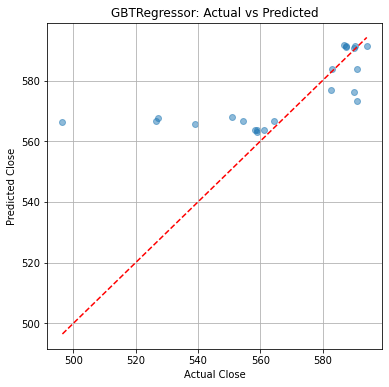

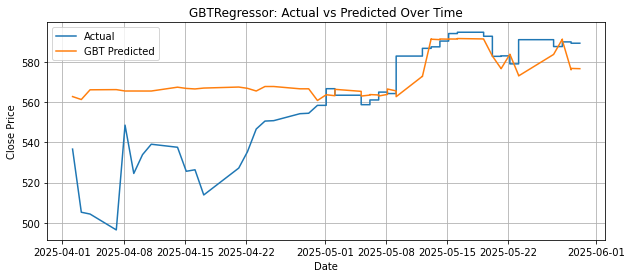

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, avg, sum as spark_sum
from pyspark.sql import DataFrame

def compute_metrics(preds: DataFrame, model_name: str):
    # Add residual column
    preds = preds.withColumn("residual", col("prediction") - col("label"))
    
    # MAE and RMSE
    metrics_row = preds.select(
        expr("avg(abs(residual))").alias("MAE"),
        expr("sqrt(avg(residual * residual))").alias("RMSE")
    ).first()
    mae  = metrics_row["MAE"]
    rmse = metrics_row["RMSE"]
    
    # R2: compute mean(label) first
    mean_label = preds.select(avg("label")).first()[0]
    
    # SSE and SST
    sse = preds.select(spark_sum((col("label") - col("prediction"))**2)).first()[0]
    sst = preds.select(spark_sum((col("label") - mean_label)**2)).first()[0]
    r2  = 1 - sse / sst if sst != 0 else None
    
    print(f"\n=== {model_name} Metrics ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
    
    return preds

preds_gbt = compute_metrics(preds_gbt, "GBTRegressor")
preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")

# Sample down for plotting
sample_gbt = preds_gbt.sample(fraction=0.5, seed=42).toPandas()
sample_xgb = preds_xgb.sample(fraction=0.5, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(sample_gbt, "GBTRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_gbt.columns:
    ts_pd = preds_gbt.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="GBT Predicted")
    plt.title("GBTRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()


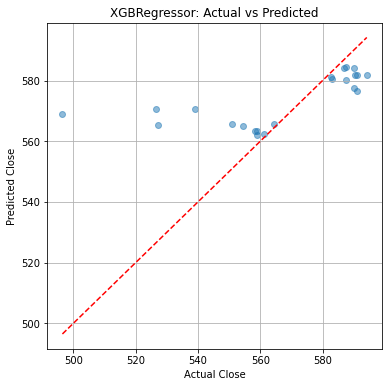

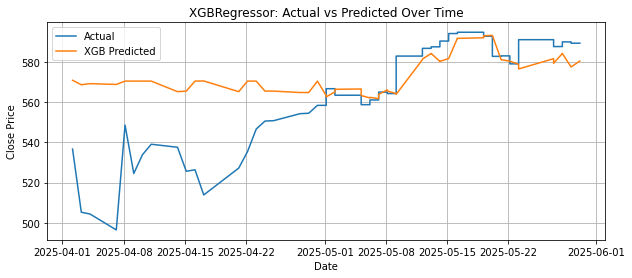

In [ ]:
# Actual vs Predicted scatter
for df, name in [(sample_xgb, "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### Test Set May


=== XGBRegressor Metrics ===
MAE : 4.3465
RMSE: 6.2754
R2  : 0.7272


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


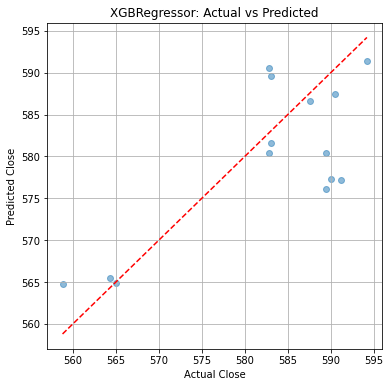

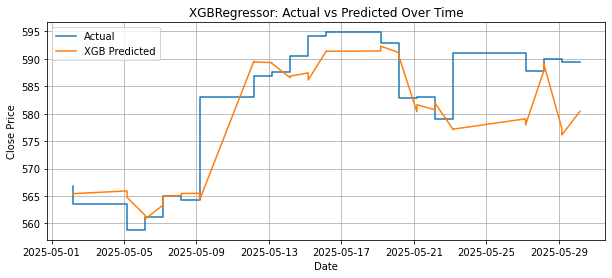

In [ ]:
preds_xgb2 = compute_metrics(preds_xgb2, "XGBRegressor")

# Sample down for plotting
sample_xgb = preds_xgb2.sample(fraction=0.5, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(sample_xgb, "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### April Feature Importance

Gain

feature importance vwap 1560.0299072265625 close 65.99795532226562 low 24.75380516052246 close_lag_1 10.260149002075195 open 8.807497024536133 trade_count 6.4395246505737305 close_lag_3 5.9815287590026855 close_lag_5 4.367863178253174 volume 3.6350181102752686 close_lag_2 3.1231400966644287 high 1.7336294651031494 close_lag_4 0.5113025903701782

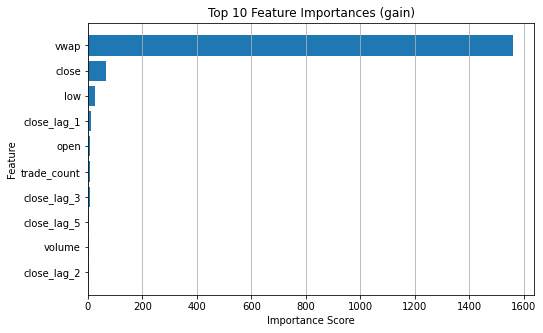

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


### May Feature Importance

feature importance vwap 1439.9691162109375 open 545.58447265625 low 436.5561828613281 close 104.78746032714844 close_lag_3 27.357933044433594 trade_count 21.720314025878906 close_lag_1 14.154147148132324 close_lag_2 9.224055290222168 high 4.451188087463379 volume 3.8440356254577637 close_lag_5 3.430814504623413 close_lag_4 1.384703278541565

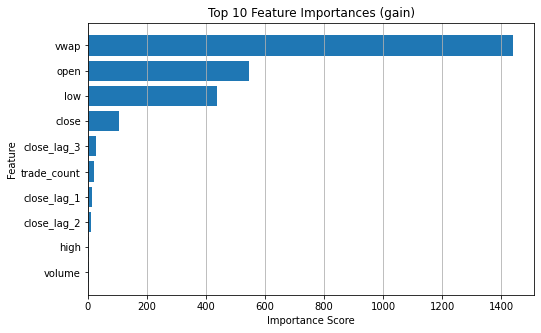

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb2.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


## Stock + News Data

### Test Set April

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, avg, sum as spark_sum
from pyspark.sql import DataFrame

def compute_metrics(preds: DataFrame, model_name: str):
    # Add residual column
    preds = preds.withColumn("residual", col("prediction") - col("label"))
    
    # MAE and RMSE
    metrics_row = preds.select(
        expr("avg(abs(residual))").alias("MAE"),
        expr("sqrt(avg(residual * residual))").alias("RMSE")
    ).first()
    mae  = metrics_row["MAE"]
    rmse = metrics_row["RMSE"]
    
    # R2: compute mean(label) first
    mean_label = preds.select(avg("label")).first()[0]
    
    # SSE and SST
    sse = preds.select(spark_sum((col("label") - col("prediction"))**2)).first()[0]
    sst = preds.select(spark_sum((col("label") - mean_label)**2)).first()[0]
    r2  = 1 - sse / sst if sst != 0 else None
    
    print(f"\n=== {model_name} Metrics ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
    
    return preds


In [ ]:
preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")

#sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(preds_xgb.toPandas(), "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### Test Set May

In [ ]:
preds_xgb2 = compute_metrics(preds_xgb2, "XGBRegressor")

#sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(preds_xgb2.toPandas(), "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb2.columns:
    ts_pd = preds_xgb2.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### April Feature Importance

Gain

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


### May Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb2.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


## Stock + News Sentiment Data

### Test Set April

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, avg, sum as spark_sum
from pyspark.sql import DataFrame

def compute_metrics(preds: DataFrame, model_name: str):
    # Add residual column
    preds = preds.withColumn("residual", col("prediction") - col("label"))
    
    # MAE and RMSE
    metrics_row = preds.select(
        expr("avg(abs(residual))").alias("MAE"),
        expr("sqrt(avg(residual * residual))").alias("RMSE")
    ).first()
    mae  = metrics_row["MAE"]
    rmse = metrics_row["RMSE"]
    
    # R2: compute mean(label) first
    mean_label = preds.select(avg("label")).first()[0]
    
    # SSE and SST
    sse = preds.select(spark_sum((col("label") - col("prediction"))**2)).first()[0]
    sst = preds.select(spark_sum((col("label") - mean_label)**2)).first()[0]
    r2  = 1 - sse / sst if sst != 0 else None
    
    print(f"\n=== {model_name} Metrics ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
    
    return preds



=== XGBRegressor Metrics ===
MAE : 26.1658
RMSE: 31.9074
R2  : -1.6202


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


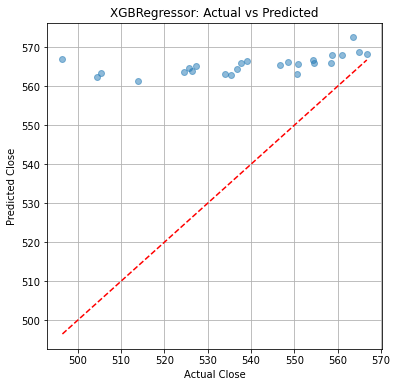

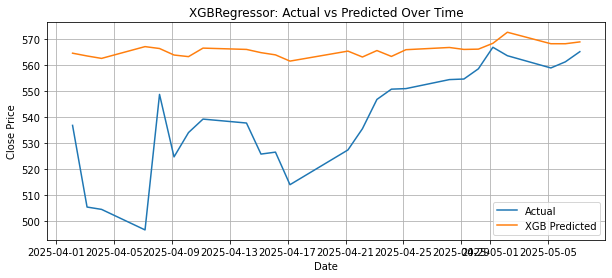

In [ ]:
preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")

#sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(preds_xgb.toPandas(), "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### Test Set May

In [ ]:
preds_xgb2 = compute_metrics(preds_xgb2, "XGBRegressor")

#sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(preds_xgb2.toPandas(), "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb2.columns:
    ts_pd = preds_xgb2.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### April Feature Importance

feature importance vwap 914.0933227539062 close_lag_1 91.58206176757812 close 75.24166870117188 high 50.005863189697266 sent_movies_negative 26.77106475830078 sent_theater_negative 18.12335205078125 low 17.842601776123047 sent_your_money_negative 13.791340827941895 count_weather 11.360734939575195 count_well 9.468204498291016 count_food 9.14008617401123 close_lag_3 9.087890625 count_style 8.883657455444336 count_books 7.974447250366211 sent_business_day_none 7.13554048538208 close_lag_2 6.675052642822266 count_crosswords_games 5.673380374908447 count_briefing 5.5966796875 count_real_estate 5.4939093589782715 sent_technology_none 5.431556701660156 close_lag_4 4.685610771179199 count_sports 3.690502405166626 trade_count 3.143587350845337 count_fashion_style 2.802882194519043 count_theater 2.644270420074463 count_times_insider 2.5703229904174805 sent_business_day_positive 2.282083511352539 sent_u_s__none 1.8481298685073853 count_magazine 1.7849024534225464 count_new_york 1.7421808242797852 close_lag_5 1.3000999689102173 sent_well_positive 1.2739461660385132 count_movies 1.2506201267242432 sent_style_none 1.2499912977218628 count_technology 1.2343558073043823 count_headway 1.2166759967803955 sent_travel_negative 0.9769608378410339 count_world 0.9300780296325684 sent_t_magazine_none 0.8530673980712891 sent_magazine_positive 0.803342342376709 count_business_day 0.6482155323028564 sent_health_negative 0.6460981369018555 volume 0.6177190542221069 sent_technology_positive 0.5707720518112183 count_opinion 0.4784609079360962 open 0.3899548053741455 count_podcasts 0.3879004716873169 sent_technology_negative 0.3424072265625 sent_books_positive 0.3209047317504883 sent_podcasts_negative 0.30204278230667114 sent_books_negative 0.28714558482170105 count_u_s_ 0.2746058702468872 count_climate 0.23047283291816711 sent_fashion_style_none 0.22441555559635162 count_science 0.16981559991836548 count_the_learning_network 0.1305035650730133 count_health 0.12693867087364197 sent_food_positive 0.11770827323198318 sent_well_negative 0.1006258949637413 sent_food_none 0.09549089521169662 count_travel 0.07590363919734955 sent_arts_negative 0.051177978515625 sent_science_positive 0.05023099109530449 count_arts 0.038591839373111725 sent_climate_positive 0.01664932630956173 sent_times_insider_positive 0.01091485284268856 sent_food_negative 0.0060783796943724155 count_t_magazine 0.005260653328150511 sent_u_s__positive 0.0035854578018188477 sent_science_negative 0.002107496140524745 count_the_upshot 0.0014643544564023614 count_obituaries 9.885251056402922E-4 sent_opinion_negative 8.433249313384295E-4 sent_the_upshot_none 6.215106113813818E-4 sent_world_positive 4.0068640373647213E-4 sent_real_estate_positive 2.931745257228613E-4 sent_arts_none 2.761030336841941E-4 sent_theater_positive 1.3203301932662725E-4 sent_new_york_none 1.294469111599028E-4 sent_health_none 1.008063554763794E-4 sent_style_negative 8.752047142479569E-5 sent_arts_positive 6.0986014432273805E-5 sent_fashion_style_negative 5.6110689911292866E-5 sent_well_none 5.523308936972171E-5 sent_new_york_positive 3.762235428439453E-5 sent_the_learning_network_positive 3.666251723188907E-5 sent_theater_none 3.599905176088214E-5 count_your_money 2.949073677882552E-5

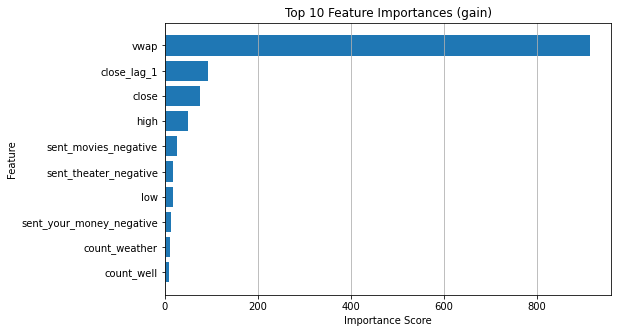

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


### May Feature Importance

feature importance low 1741.3023681640625 vwap 1366.0435791015625 high 649.3900756835938 open 94.35775756835938 sent_well_negative 59.558048248291016 close_lag_1 58.233943939208984 sent_well_none 56.872802734375 sent_weather_positive 54.3538818359375 close 52.823909759521484 close_lag_3 50.88560485839844 count_obituaries 42.68035125732422 sent_science_positive 42.173828125 sent_technology_positive 40.28784942626953 sent_travel_positive 35.24812316894531 count_health 23.226163864135742 sent_the_upshot_none 18.4141845703125 sent_style_none 18.372482299804688 count_t_magazine 18.14341163635254 close_lag_2 17.64832305908203 trade_count 17.399723052978516 count_new_york 16.837696075439453 sent_technology_none 14.808829307556152 count_world 14.803241729736328 sent_u_s__none 12.511329650878906 sent_theater_negative 11.958465576171875 count_u_s_ 11.522228240966797 sent_food_negative 9.962432861328125 close_lag_4 9.79185676574707 count_weather 6.419142246246338 count_books 5.985889911651611 sent_business_day_none 5.550446033477783 sent_weather_none 5.466662406921387 count_arts 5.017919540405273 count_sports 5.006452560424805 count_theater 4.936956882476807 sent_travel_negative 4.901019096374512 sent_magazine_positive 4.746383190155029 count_climate 3.7876548767089844 count_business_day 3.754366874694824 count_food 3.437116861343384 count_technology 3.1347122192382812 count_times_insider 2.9998109340667725 close_lag_5 2.959813117980957 sent_technology_negative 2.742889404296875 volume 2.7301700115203857 sent_podcasts_negative 2.6955108642578125 count_movies 1.9495835304260254 sent_style_positive 1.845617651939392 count_fashion_style 1.837615966796875 count_style 1.681445598602295 sent_well_positive 1.4427999258041382 count_opinion 1.346992015838623 count_magazine 1.2401000261306763 count_your_money 1.1517122983932495 sent_weather_negative 1.1152615547180176 sent_arts_negative 1.0882751941680908 sent_opinion_negative 0.7372585535049438 sent_magazine_negative 0.6193613409996033 sent_arts_positive 0.5249478220939636 sent_books_none 0.499687135219574 sent_opinion_positive 0.4703056514263153 sent_science_none 0.40082383155822754 sent_climate_positive 0.3900595009326935 count_science 0.3603062927722931 sent_the_learning_network_negative 0.2879904806613922 sent_books_negative 0.28794461488723755 count_podcasts 0.2697102427482605 count_the_upshot 0.21476784348487854 count_real_estate 0.14858457446098328 count_well 0.12172762304544449 sent_t_magazine_negative 0.10344914346933365 sent_opinion_none 0.08783786743879318 sent_books_positive 0.08573602139949799 sent_fashion_style_none 0.07828481495380402 sent_u_s__negative 0.07321266829967499 count_crosswords_games 0.07285946607589722 sent_business_day_positive 0.06392161548137665 sent_movies_negative 0.052442289888858795 sent_the_learning_network_positive 0.05038442462682724 sent_food_none 0.031674519181251526 sent_travel_none 0.021766316145658493 sent_world_positive 0.02084699273109436 sent_fashion_style_negative 0.01930774375796318 sent_u_s__positive 0.016592921689152718 sent_movies_positive 0.016000544652342796 sent_theater_positive 0.01529311016201973 count_travel 0.014387552626430988 sent_world_negative 0.011735694482922554 sent_podcasts_positive 0.0023316219449043274

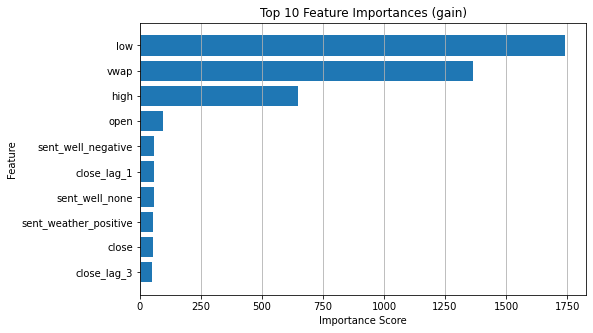

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb2.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()

# Bonus Points: Graph-Based Analysis Using GraphFrames

To complement our numerical and text-based features, we leveraged graph analytics to explore the structure and dynamics of topic relationships over time. Using the GraphFrames library in PySpark, we constructed daily co-occurrence graphs where each node represents a topic mentioned in the news, and edges link topics that co-appeared in articles within the same time window.

For each day, we computed the **PageRank** of every topic to quantify its centrality within that day's topic network. This method allowed us to identify which topics were not only frequent but also structurally influential—those that served as bridges between multiple other themes.

By tracking how PageRank scores evolved before and after significant events (e.g., Trump's tariff announcement on April 3rd, 2025), we could detect shifts in the news agenda and highlight emerging or declining narratives.

These graph-based scores were then integrated into our machine learning pipeline as features, enriching our market prediction model with a structural dimension of media influence.


In [ ]:
df_news = spark.table("news_tfidfs")
display(df_news)

window_start window_end count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-02-05T00:00:00.000+0000 2025-02-06T00:00:00.000+0000 0 11 0 5 4 13 0 2 5 0 0 4 0 3 0 0 5 3 8 0 12 4 0 0 2 4 1 6 0 0 3 3 1 2 0 2 50 2 2 22 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(46, 189, 307, 363, 503, 628, 846, 972, 1525, 1586, 1945, 1957, 2066, 2108, 2166, 2187, 2195, 2295, 2526, 2736, 2888, 3083, 3283, 3561, 4001, 4686, 4719, 4744, 4795, 5672, 6256, 6456, 6972, 7134, 7342, 7625, 7797, 7913, 8025, 8086, 8735, 9187, 9331, 10374, 10389, 10506, 10755, 10852, 10875, 11130, 11160, 11519, 12112, 12138, 12342, 12364, 12409, 12906, 13178, 13283, 14093, 14429, 14521, 14739, 15181, 15874, 15910, 16064, 16108, 16315), values -> List(3.549279263362161, 3.124396069396895, 4.495422958385997, 7.298783339292532, 5.912488978172641, 4.856436303923328, 4.856436303923328, 6.200171050624422, 3.5145937053742706, 6.8933182311843675, 3.291450154060061, 4.659726009677273, 4.120729508944586, 3.7152644008364217, 6.8933182311843675, 3.6481250979987934, 5.42698116239094, 4.696093653848148, 4.002946473288203, 5.912488978172641, 4.303051065738541, 5.507023870064477, 5.689345426858432, 4.557943315367331, 3.3572015316228416, 6.605636158732587, 6.605636158732587, 4.624634689866003, 4.230730404158915, 6.382492607418377, 3.1716489542474404, 6.046020370797164, 6.200171050624422, 5.047491540686036, 7.298783339292532, 4.465569995236316, 3.124396069396895, 2.9544356579598947, 3.5260224011978933, 5.352873190237219, 4.428556393259641, 4.381012607208253, 7.298783339292532, 4.141782918142419, 5.352873190237219, 5.689345426858432, 3.9488792520179268, 3.492120849522212, 4.900888066494161, 6.046020370797164, 5.101558761956312, 6.382492607418377, 4.495422958385997, 4.659726009677273, 4.141782918142419, 7.298783339292532, 4.021638606300355, 3.32849142574041, 6.605636158732587, 5.594035247054107, 4.813876689504531, 3.802275777826052, 3.2645427011401367, 5.507023870064477, 5.158717175796261, 3.881056655679166, 4.733833981830995, 4.328368873722831, 8.370536060164316, 4.141782918142419)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(296, 893, 2680, 3626, 5014, 5186, 5755, 5809, 6368, 6445, 7571, 7806, 8145, 8273, 8889, 9048, 9499, 9958, 9976, 10483, 10570, 10666, 10852, 12126, 12471, 12515, 12677, 13785, 13823, 14860, 15067, 15851, 15993), values -> List(6.605636158732587, 4.100110221741851, 5.101558761956312, 4.4365824583630635, 4.557943315367331, 4.4365824583630635, 6.382492607418377, 3.376810003011218, 6.200171050624422, 3.881056655679166, 6.200171050624422, 3.6099038851785954, 4.18526803

In [ ]:
from pyspark.sql.functions import expr, col, lit
from graphframes import GraphFrame
from functools import reduce
from pyspark.sql import DataFrame

# Identify topic columns
topic_cols = [c for c in df_news.columns if c.startswith("count_") and c != "count_"]

# Melt wide to long format
melted = df_news.selectExpr(
    "window_start",
    f"stack({len(topic_cols)}, " +
    ", ".join([f"'{col[6:]}', `{col}`" for col in topic_cols]) +
    ") as (topic, value)"
)

# Get distinct dates
dates = melted.select("window_start").distinct().toPandas()["window_start"].tolist()

# Compute PageRank per day
results = []
for day in dates:
    day_topics = melted.filter((col("window_start") == day) & (col("value") > 0))

    joined = day_topics.alias("a").join(
        day_topics.alias("b"),
        (col("a.window_start") == col("b.window_start")) & (col("a.topic") < col("b.topic"))
    )

    edges = joined.select(col("a.topic").alias("src"), col("b.topic").alias("dst"))
    vertices = day_topics.select(col("topic").alias("id")).distinct()

    g_day = GraphFrame(vertices, edges)

    try:
        pr_day = g_day.pageRank(resetProbability=0.15, maxIter=10)
        pr_day_df = pr_day.vertices.withColumn("timestamp", lit(day))  # you can rename to "window_start" if preferred
        results.append(pr_day_df)
    except:
        pass

# Combine all results
pagerank_by_day = reduce(DataFrame.unionByName, results)

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [ ]:
# Persist and register
OUT_PATH = "/mnt/nyt/pagerank_by_day"

(
    pagerank_by_day
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS pagerank_by_day
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[35]: DataFrame[]

To avoid always having to run it, let's store the data.

In [ ]:
pagerank_by_day = spark.table("pagerank_by_day")
display(pagerank_by_day.limit(3))

id pagerank timestamp Health 0.43829368765293525 2025-02-26T00:00:00.000+0000 Real_Estate 0.5943149056289686 2025-02-26T00:00:00.000+0000 Food 0.42042559966708415 2025-02-26T00:00:00.000+0000

In [ ]:
pagerank_by_day.select("id").distinct().show()

+--------------------+
|                  id|
+--------------------+
|               World|
|           Education|
|             Science|
|                Food|
|                Well|
|          The_Upshot|
|               Style|
|             Climate|
|             Opinion|
|              Travel|
|              Health|
|       Times_Insider|
|            Magazine|
|            New_York|
|         Real_Estate|
|         Corrections|
|              Movies|
|The_Learning_Network|
|               Books|
|          Your_Money|
+--------------------+
only showing top 20 rows



We can proceed with some visualization.

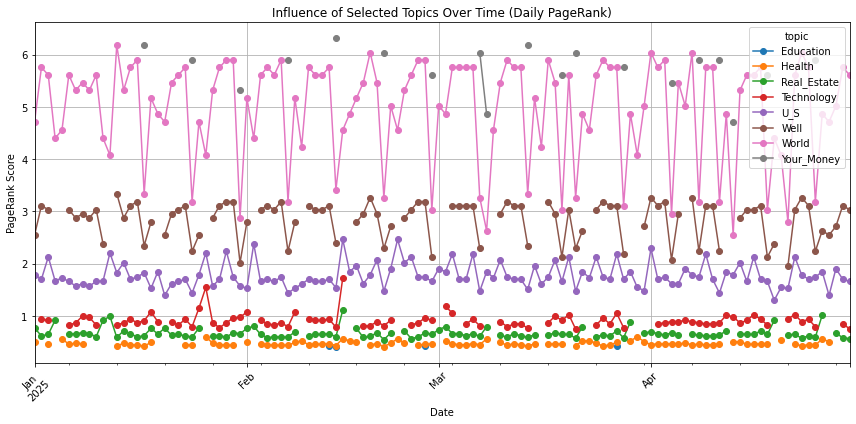

In [ ]:
from pyspark.sql.functions import expr, col, lit
from graphframes import GraphFrame
import matplotlib.pyplot as plt

selected_topics = ["Technology", "Health", "Your_Money", "World", "U_S", "Education", "Real_Estate", "Well"]

trend_df = (
    pagerank_by_day
    .filter(col("id").isin(selected_topics))
    .select(col("timestamp"), col("id").alias("topic"), col("pagerank"))
)

# Convert to Pandas and pivot
trend_pd = trend_df.toPandas()
pivoted = trend_pd.pivot(index="timestamp", columns="topic", values="pagerank")

# Plot
pivoted.plot(figsize=(12, 6), marker='o')
plt.title("Influence of Selected Topics Over Time (Daily PageRank)")
plt.ylabel("PageRank Score")
plt.xlabel("Date")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph shows how the influence of selected topics evolved over time based on their daily PageRank scores in the co-occurrence network. Notably:

- Technology consistently dominated the network, often reaching the highest PageRank values, indicating strong and frequent connections with other topics.

- World and U.S. also maintained relatively high and stable influence, suggesting ongoing relevance and centrality in the news landscape.

- In contrast, topics like Health, Real_Estate, and Education remained lower in influence, showing smaller and more stable PageRank scores, likely due to narrower or more focused coverage.

- The sharp fluctuations in some topics (like "Well" and "Your_Money") may reflect more episodic attention in the media.

Overall, the data highlights which topics were structurally central in daily news narratives and how that centrality shifted over time.



In [ ]:
from pyspark.sql.functions import to_date

days_to_compare = ["2025-04-01", "2025-04-03"]
import pandas as pd

comparison_df = (
    pagerank_by_day
    .withColumn("date", to_date("timestamp"))
    .filter(col("date").isin(["2025-04-01", "2025-04-03"]))
    .orderBy("date", col("pagerank").desc())
    .toPandas()
)

# Ensure dates are datetime type
comparison_df["date"] = pd.to_datetime(comparison_df["date"])

# Pivot and compute difference
pivoted = comparison_df.pivot(index="id", columns="date", values="pagerank").fillna(0)

# Rename columns for convenience
pivoted.columns = [col.strftime("%Y-%m-%d") for col in pivoted.columns]

# Compute difference
pivoted["diff"] = pivoted["2025-04-03"] - pivoted["2025-04-01"]
pivoted = pivoted.sort_values(by="diff", ascending=False)

print(pivoted.head(10))


                  2025-04-01  2025-04-03      diff
id                                                
Weather             0.000000    2.236511  2.236511
Times_Insider       0.000000    1.228453  1.228453
Technology          0.000000    0.867349  0.867349
Obituaries          0.000000    0.530249  0.530249
Automobiles         0.000000    0.339333  0.339333
Food                0.413780    0.438294  0.024514
Crosswords_Games    0.398388    0.420426  0.022038
Corrections         0.384189    0.404070  0.019881
Climate             0.371048    0.389039  0.017991
Business_Day        0.358847    0.375174  0.016327



One notable shift following Trump’s tariff announcement on **April 3rd, 2025**, is the sudden emergence of the **"Times_Insider"** topic, which jumped from a PageRank score of **0.0** on April 1st to **1.23** on April 3rd.

This indicates that *The New York Times* dedicated significant behind-the-scenes reporting or editorial reflection on the announcement and its broader implications. Since "Times Insider" focuses on **meta-journalism**, explaining how stories are reported, its rise suggests that the newspaper aimed to increase transparency or provide context around political coverage during a period of heightened reader interest and policy significance.


### Analyzing Topic Centrality on April 3rd, 2025
To understand the shift in public discourse following major news such as Trump’s tariff announcement, we visualize the top 10 most central news topics by PageRank score on April 3rd, 2025. This helps identify which themes became more prominent in the media landscape on that day.

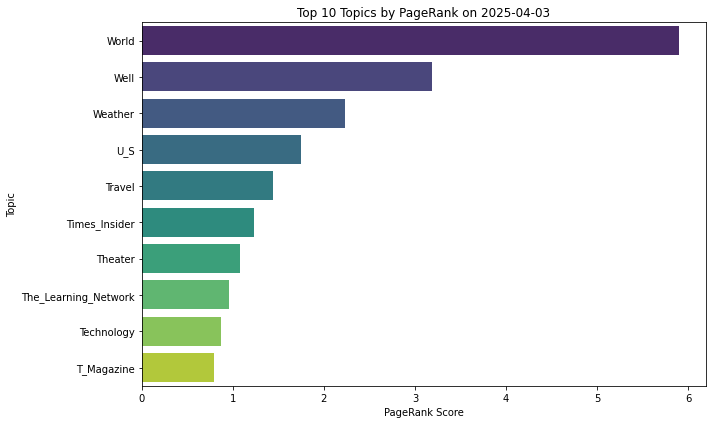

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date

# Select April 3rd topics
day = "2025-04-03"
top_topics_apr3 = (
    pagerank_by_day.withColumn("date", to_date("timestamp"))
    .filter(col("date") == day)
    .orderBy(col("pagerank").desc())
    .limit(10)
    .toPandas()
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_topics_apr3, x="pagerank", y="id", palette="viridis")
plt.title(f"Top 10 Topics by PageRank on {day}")
plt.xlabel("PageRank Score")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

### Visualizing the Topic Co-occurrence Network for April 3rd, 2025
To deepen our understanding of the relationships between news topics on the day of Trump’s tariff announcement (April 3rd, 2025), we construct a co-occurrence network. Each node represents a topic that appeared in at least one article that day, and edges connect topics that co-occurred in the same time window.

We then compute PageRank scores using NetworkX and visualize the graph, where node size reflects each topic's centrality. This allows us to explore structural prominence beyond mere frequency counts.

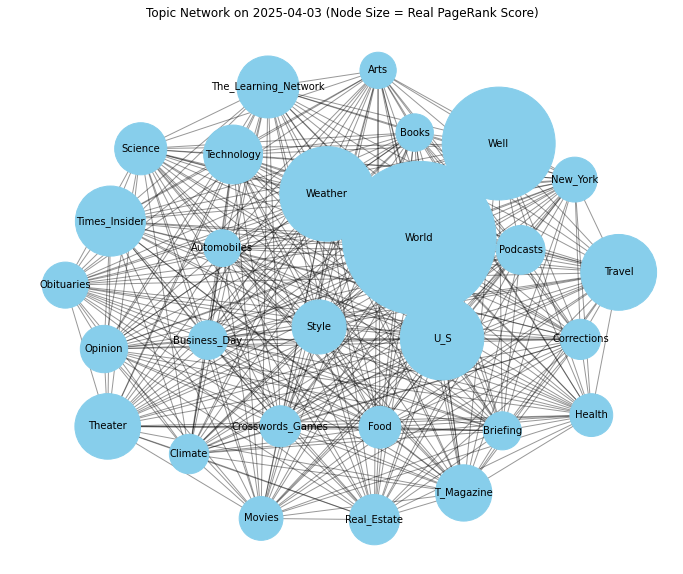

In [ ]:
from pyspark.sql.functions import to_date, col
from pyspark.sql import Row
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Select April 3rd PageRank from stored results
day = "2025-04-03"
pr_scores = (
    pagerank_by_day.withColumn("date", to_date("timestamp"))
    .filter(col("date") == day)
    .select("id", "pagerank")
    .toPandas()
    .set_index("id")["pagerank"]
    .to_dict()
)

# Step 2: Prepare topic graph based on co-occurrence
topic_cols = [c for c in merged.columns if c.startswith("count_") and c != "count_"]
melted = merged.selectExpr(
    "timestamp",
    f"stack({len(topic_cols)}, " +
    ", ".join([f"'{col[6:]}', `{col}`" for col in topic_cols]) +
    ") as (topic, value)"
)
melted_date = melted.withColumn("date", to_date("timestamp"))
topics_on_day = (
    melted_date.filter((col("date") == day) & (col("value") > 0))
    .select("topic").distinct().toPandas()["topic"].tolist()
)

if topics_on_day:
    pairs = [Row(src=a, dst=b) for a, b in combinations(sorted(topics_on_day), 2)]
    edges_df = spark.createDataFrame(pairs)
    edges_pd = edges_df.toPandas()
    
    # Build graph
    G = nx.from_pandas_edgelist(edges_pd, source="src", target="dst")
    
    # Assign node sizes using real PageRank scores
    sizes = [pr_scores.get(node, 0) * 4000 for node in G.nodes()]  # Adjust multiplier as needed

    # Plot
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(f"Topic Network on {day} (Node Size = Real PageRank Score)")
    plt.axis('off')
    plt.show()
else:
    print(f"No topics found for {day}")
